# Capstone: SG Food Recommender
Author: Choo Wende

---

<details>
1. https://towardsdatascience.com/yelp-restaurant-recommendation-system-capstone-project-264fe7a7dea1
2. https://github.com/dominiczrong/yelp-restaurant-recommendation-system
3. https://github.com/jcy10/DSI-Capstone-Project
4. https://github.com/nikasso/movie2vec
5. https://github.com/dnaylah/movie-recommender
6. https://towardsdatascience.com/foodiebuddie-how-we-built-singapores-first-food-recommender-b7f3eed0ac77
7. https://github.com/terenceneo/Social-Analytics </details>

## Libraries Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import re
import gensim 
import gensim.corpora as corpora
import spacy

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from matplotlib import image
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## Part 2: Exploratory Data Analysis (EDA) and Sentiment Analysis

## 4. EDA

### Import Data

In [2]:
# Read merged dataframe
df = pd.read_csv('../data/combined_data.csv')
df.shape

C:\Users\Wende.Joanne\AppData\Local\Temp\ipykernel_16072\2023375282.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/combined_data.csv')


(25485, 193)

In [3]:
# Display Dataframe info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25485 entries, 0 to 25484
Columns: 193 entries, rest_name to category_middle_eastern
dtypes: float64(5), int64(176), object(12)
memory usage: 37.5+ MB


In [4]:
# Display first 2 rows of merged dataframe
df.head(2)

,rest_name,href,address,postal_code,latitude,longitude,opening,img,star_rating,review_count,...,category_irish,category_salad,category_delis,category_food_court,category_thai,category_dim_sum,category_seafood,category_henghwa,category_kopitiam,category_middle_eastern
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,0,0,0
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
# Instantiate dataframe columns
rest_info_col = [
    'rest_name',
    'href',
    'address',
    'postal_code',
    'latitude',
    'longitude',
    'opening',
    'img',
    'star_rating',
    'review_count',
    'location',
    'price_range'
]

user_info_col = [
    'username',
    'userid',
    'user_location',
    'user_rating',
    'review_date',
    'comment'
]

cat_col = df.drop(columns = rest_info_col + user_info_col).columns.tolist()

In [6]:
# Display datatype for non-categorial columns
df[rest_info_col + user_info_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25485 entries, 0 to 25484
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rest_name      25485 non-null  object 
 1   href           25485 non-null  object 
 2   address        25485 non-null  object 
 3   postal_code    25485 non-null  object 
 4   latitude       25485 non-null  float64
 5   longitude      25485 non-null  float64
 6   opening        25485 non-null  object 
 7   img            25485 non-null  object 
 8   star_rating    25485 non-null  float64
 9   review_count   25485 non-null  float64
 10  location       25485 non-null  object 
 11  price_range    25485 non-null  float64
 12  username       25485 non-null  object 
 13  userid         25485 non-null  object 
 14  user_location  25485 non-null  object 
 15  user_rating    25485 non-null  int64  
 16  review_date    25485 non-null  object 
 17  comment        25485 non-null  object 
dtypes: flo

In [7]:
# Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

### Map Overview of Restaurant Locations

In [8]:
# load image as pixel array
sg_map_data = image.imread('../data/sg_map_grayscale.png')

# summarize shape of the pixel array
print(sg_map_data.dtype)
print(sg_map_data.shape)

# Define longitude and latitude for sg_map
lon_lat_boundary = (103.6, 104.1, 1.2, 1.5)


float32
(803, 1342)


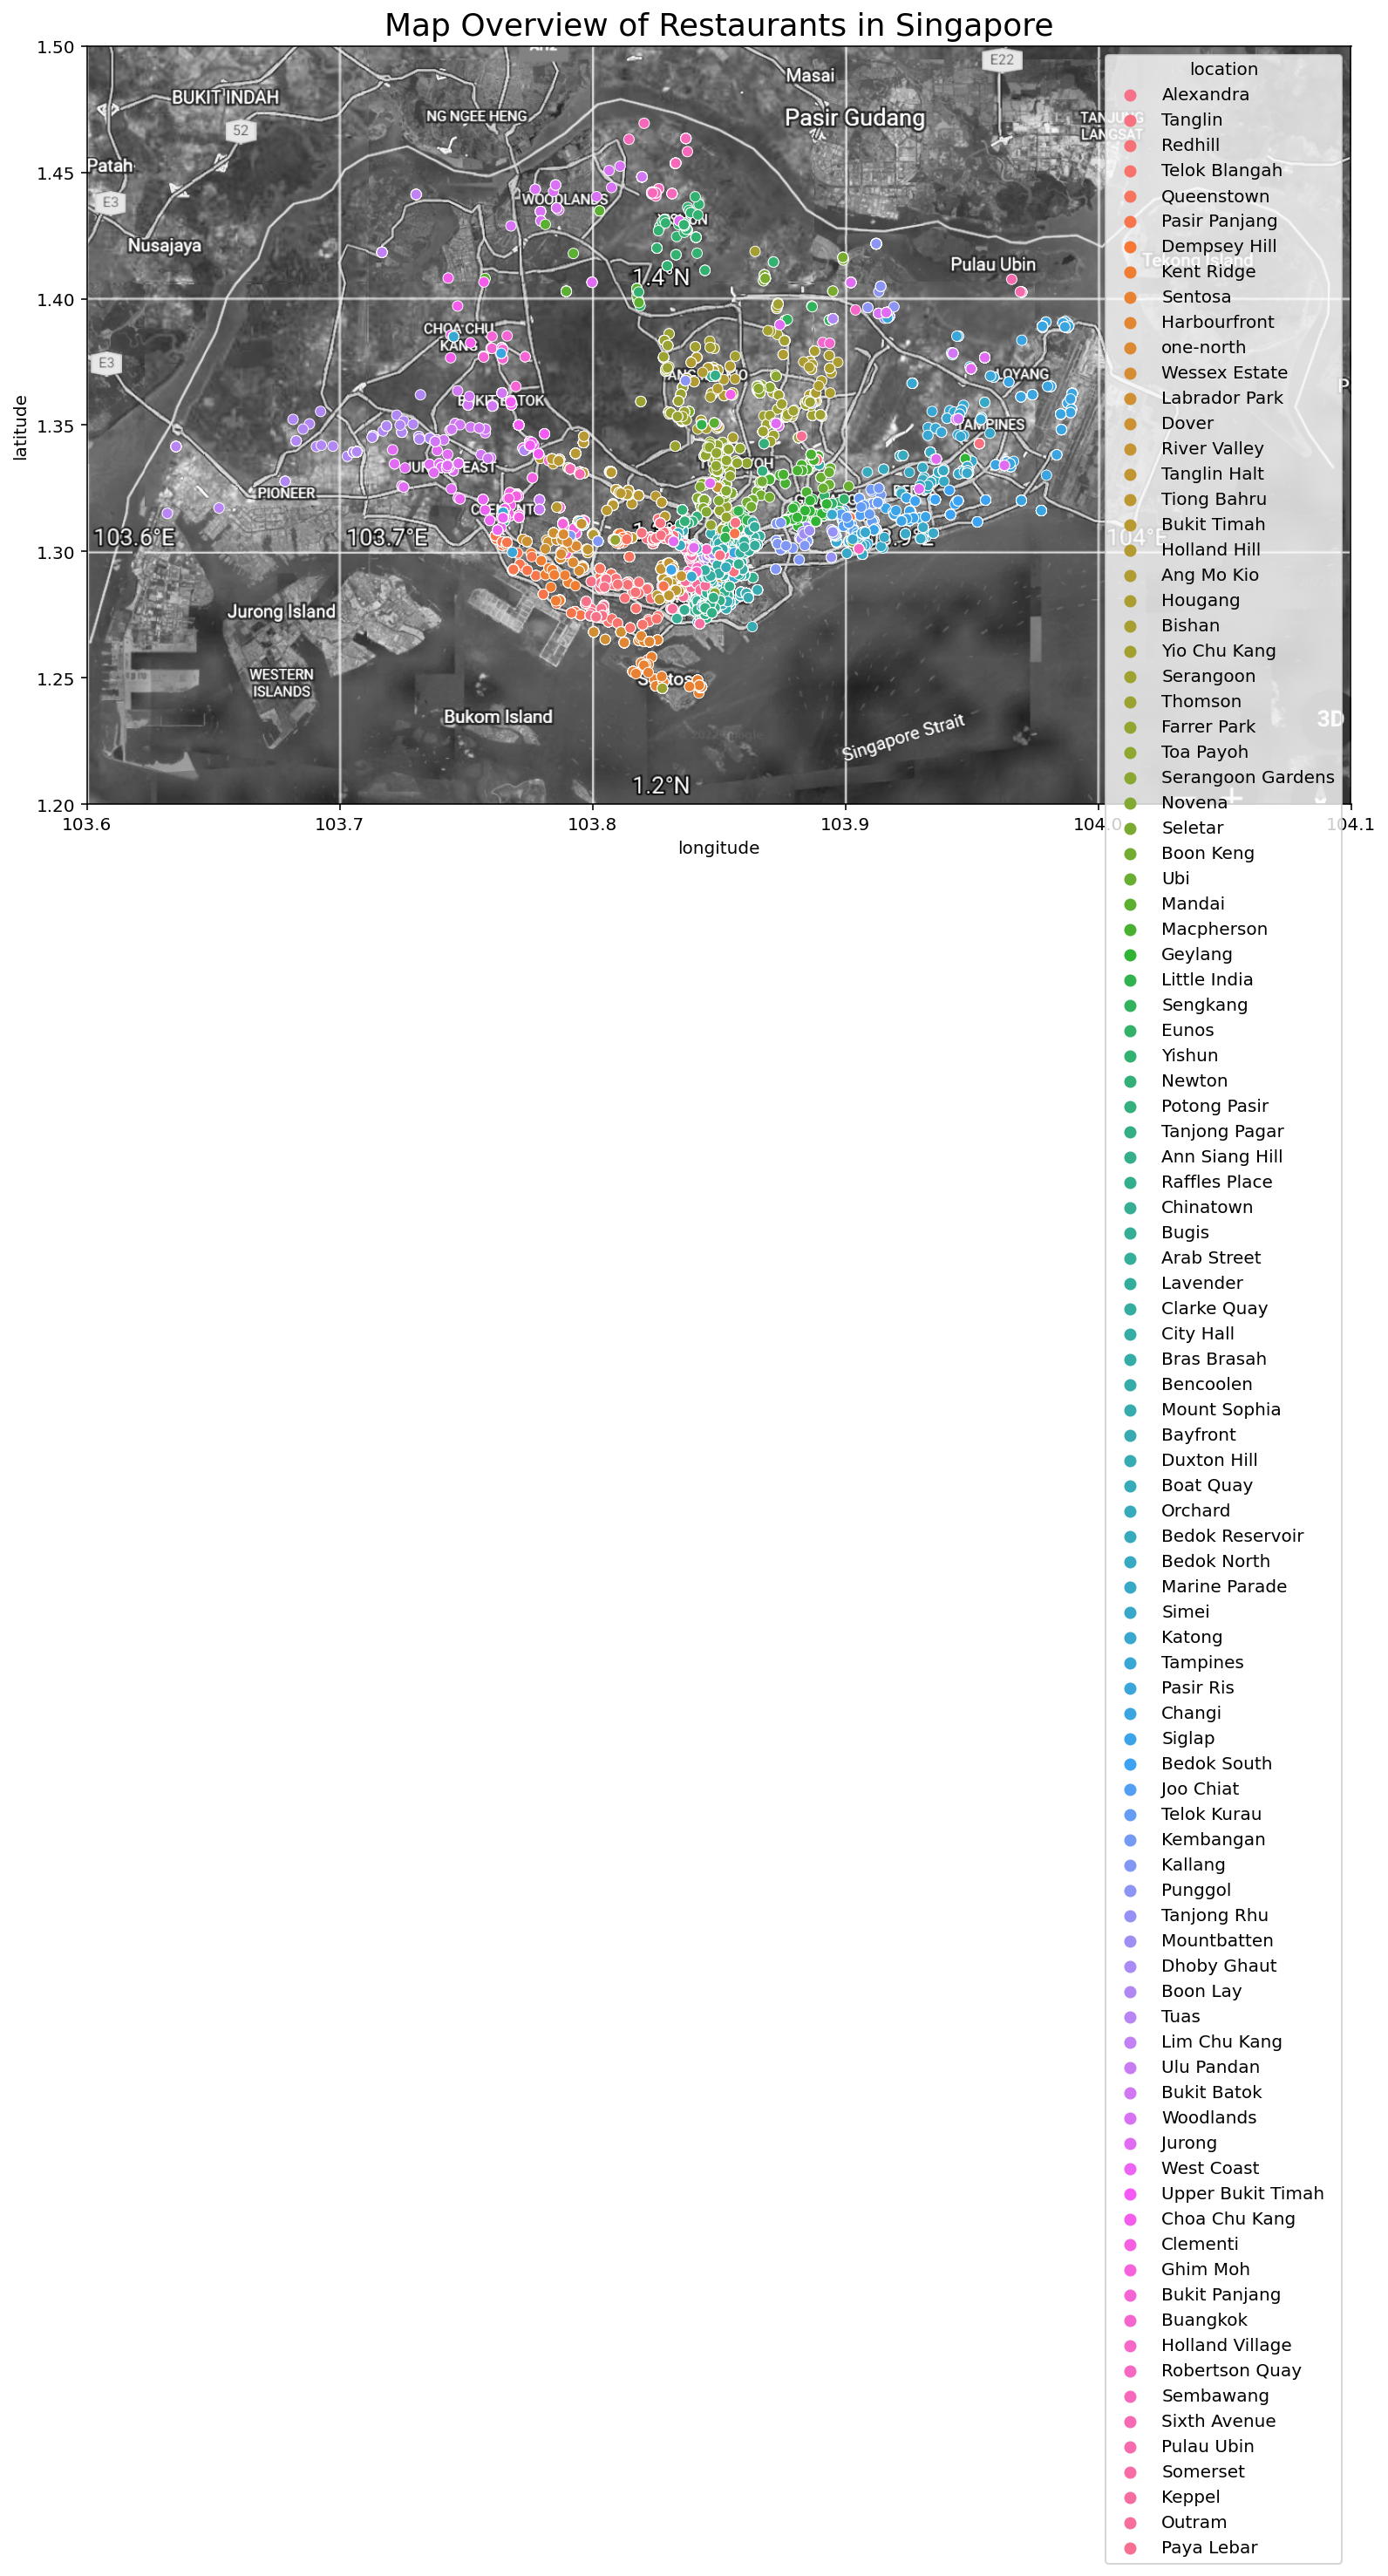

In [9]:
# Plot overview of restaurant locations
plt.figure(figsize=(15,8))
plt.title('Map Overview of Restaurants in Singapore', size=18)
plt.imshow(sg_map_data, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_boundary);
sns.scatterplot(data=df, y='latitude', x='longitude', hue='location');

### Reviews Density Per Restaurant
1. There are a total of about 3,941 restaurants, with an average of about 6 comments per restaurants.
2. However, majority of the restaurants have between 1 and 7 reviews.
3. This is assessed to be adequate to build the recommendation system. 

In [10]:
# Create dataframe of restaurants and review count
comment_count_df = df.groupby(['rest_name', 'href']).count()[['comment']].sort_values(by='comment', ascending=False)
comment_count_df = comment_count_df.reset_index(drop=False)
comment_count_df.head()

,rest_name,href,comment
0,Tian Tian Hainanese Chicken Rice,http://www.yelp.com/biz/tian-tian-hainanese-ch...,345
1,Jumbo Seafood,http://www.yelp.com/biz/jumbo-seafood-singapor...,184
2,Jumbo Seafood,http://www.yelp.com/biz/jumbo-seafood-singapor...,176
3,Din Tai Fung,http://www.yelp.com/biz/din-tai-fung-singapore...,175
4,Jumbo Seafood,http://www.yelp.com/biz/jumbo-seafood-singapor...,137


In [11]:
# Describe review counts of restaurants
comment_count_df.describe()

,comment
count,3941.000000
mean,6.466633
std,12.428566
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,345.000000


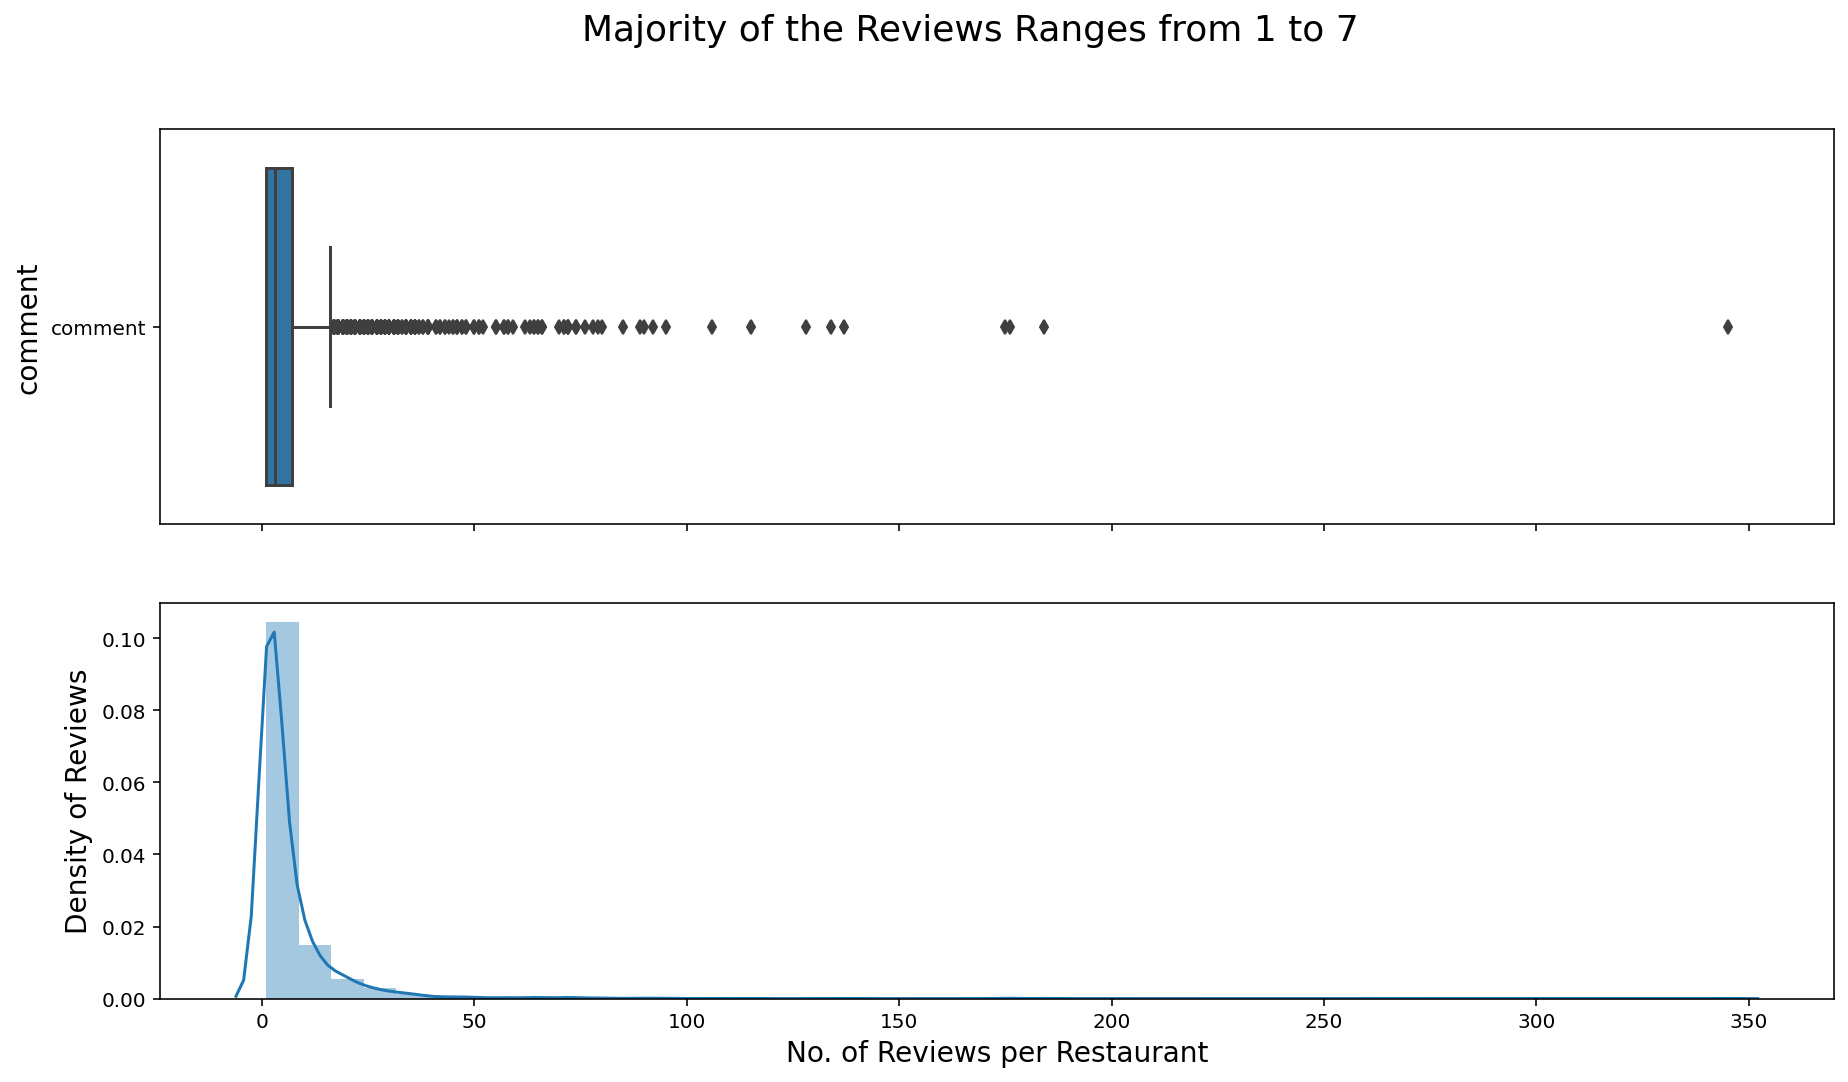

In [12]:
# Boxplot and distribution plot of reviews per restaurants
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 8))
ax = ax.ravel()

plt.suptitle("Majority of the Reviews Ranges from 1 to 7", size=18)

# Boxplot of review counts per restaurant
sns.boxplot(data=comment_count_df, orient='h', ax=ax[0])
ax[0].set_ylabel("comment", size=14)

# Plotting the distribution
sns.distplot(comment_count_df["comment"],  
             bins=45,
             ax=ax[1])
ax[1].set_xlabel("No. of Reviews per Restaurant", size=14)
ax[1].set_ylabel("Density of Reviews", size=14)

plt.show()

### Reviews Density Per User
1. There are a total of about 7,200 users, with an average of about 3 review submissions per user.
2. However, majority of the users(about 6,000) have either 1 or 2 reviews.
3. To build the recommendation system, users with more than 4 reviews will be considered. This will amount to a user base of about 1,000 users. This is assessed to be adequate to build the recommender system. 
4. For users with more than 4 review submissions, the average number of reviews per user is about 16 submissions. Majority of the users submits between 6 and 16 reviews.

In [13]:
# Create a dataframe of review counts based on users. 
user_count_df = df.groupby(['username', 'userid']).count()[['comment']].sort_values(by='comment', ascending=False)
user_count_df = user_count_df.reset_index()

# Display top 5 users based on highest review submissions 
user_count_df.head()

,username,userid,comment
0,Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,313
1,Ancy N.,4y4obgWxi_CL25nRHrhuEA,183
2,Melissa Y.,H8mXfh5XgGCqmMLwVH7k5A,156
3,Lam N.,Y4pO9yZociD96rtJ5vRyDw,153
4,Carolyn L.,Q1oMmm7tKPOzA7_gqcV4zg,153


In [14]:
# Describe the dataframe
user_count_df.describe()

,comment
count,7266.000000
mean,3.507432
std,9.925241
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,313.000000


In [15]:
# there are about 1,000 users with more than 4 review submissions. 
user_base_df = user_count_df[user_count_df['comment']>4]
len(user_base_df)

999

In [16]:
# Describe the dataframe for users with more than 4 reviews submissions
user_base_df.describe()

,comment
count,999.000000
mean,16.169169
std,22.949985
min,5.000000
25%,6.000000
50%,8.000000
75%,16.000000
max,313.000000


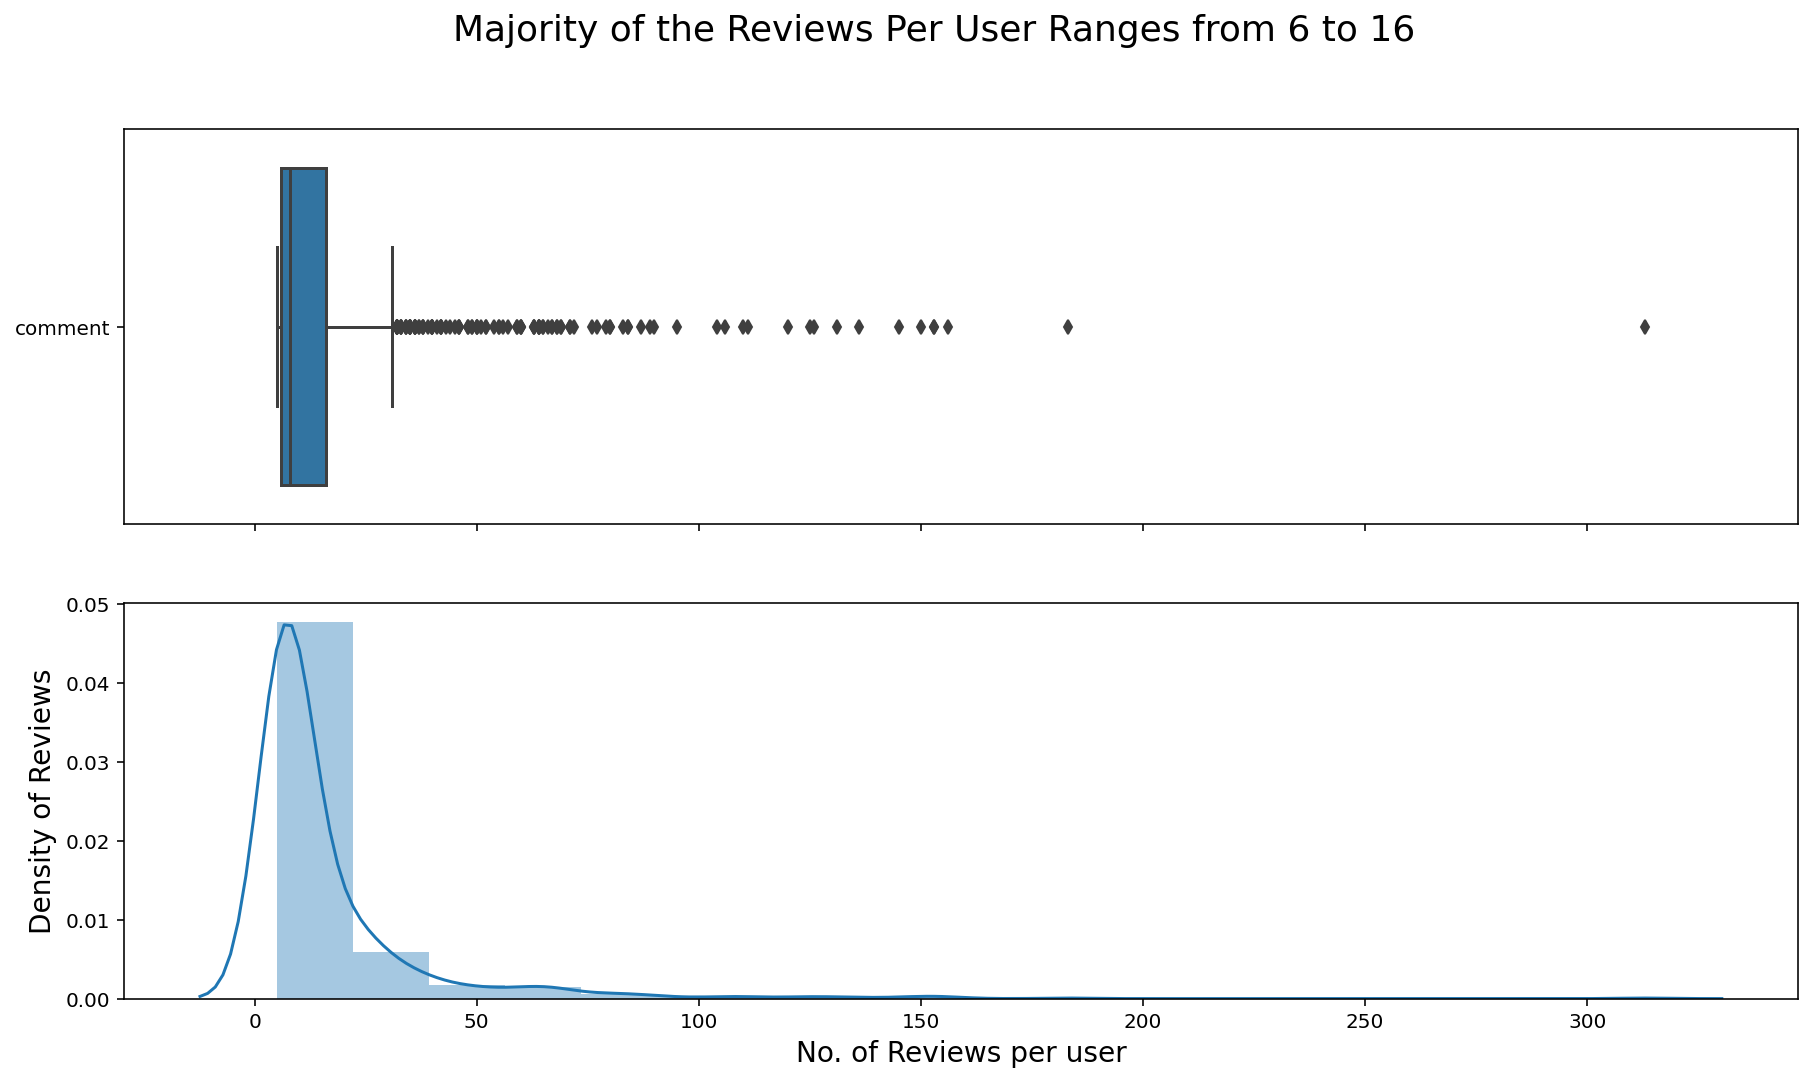

In [17]:
# Boxplot and distribution plot of reviews per user with more than 4 reviews submissions
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 8))
ax = ax.ravel()

plt.suptitle("Majority of the Reviews Per User Ranges from 6 to 16", size=18)

# Box plot of reviews per user
sns.boxplot(data=user_base_df, orient='h', ax=ax[0])

# Plotting the distribution
sns.distplot(user_base_df["comment"],
             bins=18, 
             ax=ax[1])
ax[1].set_xlabel("No. of Reviews per user", size=14)
ax[1].set_ylabel("Density of Reviews", size=14)

plt.show()

### Reviews Count by Users' Origin
1. There are 1,560 local users and 5,706 overseas users. 
2. 10,920 reveiws are submitted by locals while 14,565 reviews are submitted by overseas users. 

In [18]:
# Create label to identify local user
df['local_user'] = df['user_location'].map(lambda x: 1 if x == 'Singapore, Singapore' else 0)

In [19]:
# Get the number of local users and overseas users. 
df[['local_user', 'userid']].drop_duplicates()['local_user'].value_counts()

0    5706
1    1560
Name: local_user, dtype: int64

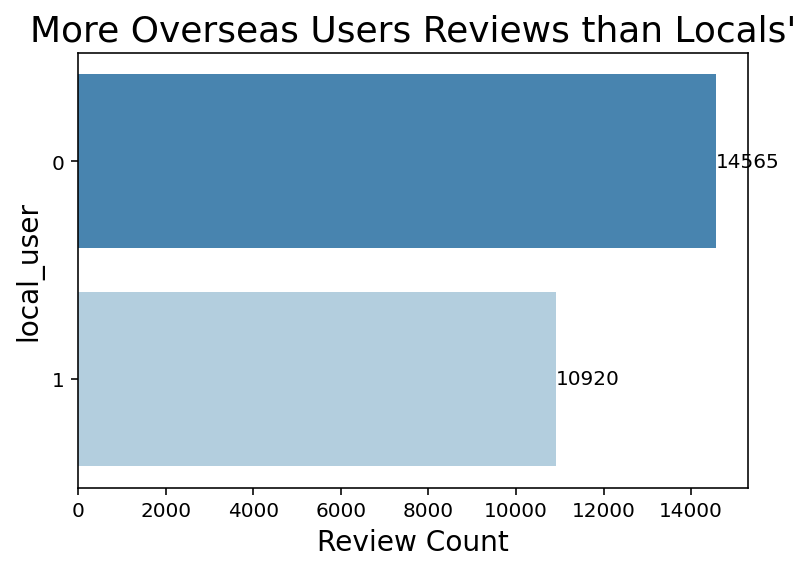

In [20]:
# Plot reviews by users origin.
ax = sns.barplot(x=df.groupby(by=['local_user']).count()['comment'].values,
                 y=df.groupby(by=['local_user']).count()['comment'].index, 
                 orient='h',
                 palette='Blues_r')
ax.set_xlabel("Review Count", size=14)
ax.set_ylabel("local_user", size=14)
ax.set_title('More Overseas Users Reviews than Locals\'', size=18)
ax.bar_label(ax.containers[0]);

### Reviews Density by Year
1. There is significant reduction in reviews submitted in 2020 and 2021. This is likely due to the COVID-19 measures where restaurants are closed or reduction in number of persons allowed to dine out. People have also switched to food delivery services and provided review on these platforms. 
2. In 2022, there is an increasing trend of reviews submission. This is likely due to the easing of COVID-19 restrictions. 

In [21]:
# Create Dataframe for reviews by year.
review_yr_df = df.review_date.dt.year.value_counts().reset_index()
review_yr_df.rename(columns = {'index':'review_yr', 
                               'review_date':'review_count'}, 
                    inplace=True)

review_yr_df

,review_yr,review_count
0,2016,3989
1,2015,3731
2,2017,3111
3,2012,3001
4,2014,2678
5,2018,2669
6,2013,2509
7,2019,2370
8,2020,785
9,2022,339


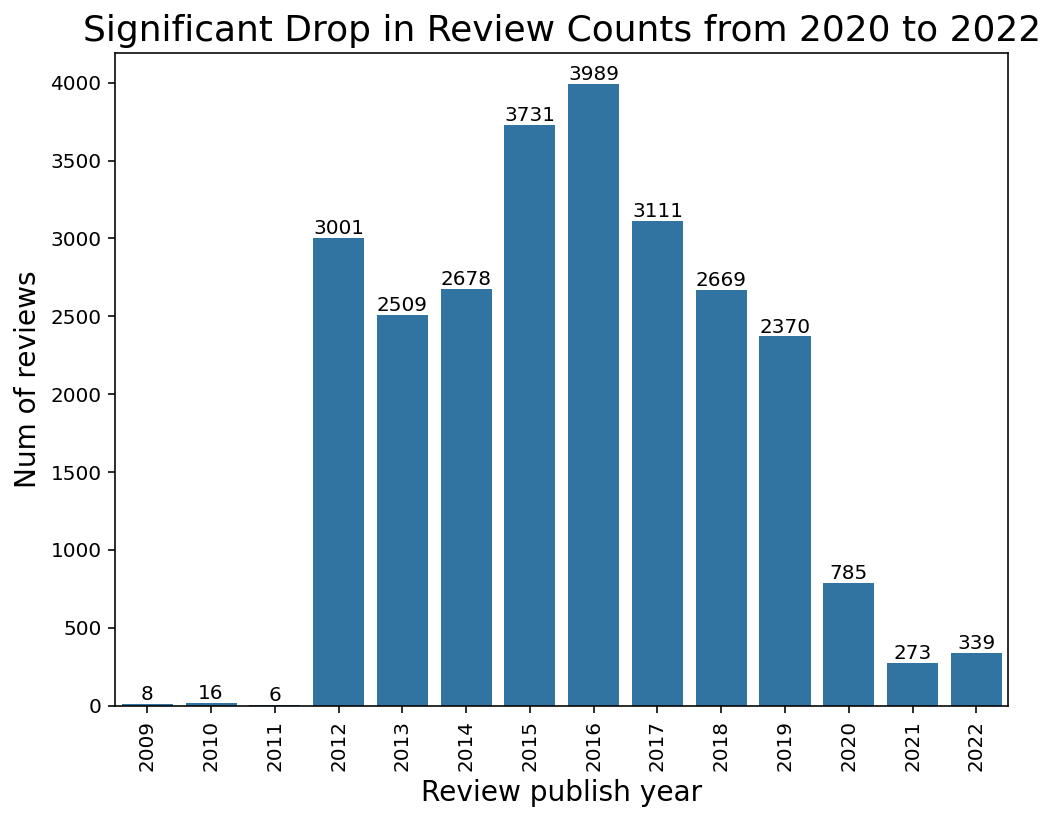

In [22]:
# Plotting in a bar graph of review count by year

plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
plt.title("Significant Drop in Review Counts from 2020 to 2022", fontsize=18)

ax = sns.barplot(x="review_yr", y="review_count", data=review_yr_df, orient="v", color="tab:blue")
ax.set_xlabel("Review publish year", size=14)
ax.set_ylabel("Num of reviews", size=14)
ax.bar_label(ax.containers[0]);

### Reviews Density by Month
1. Generally, there are higher number reviews between Jul and Sep. 
2. Review count is highest in August as there is spike in review submissions in August 2012. This is because Yelp was first introduced in Singapore in Aug/Sep 2012 ([source](https://en.wikipedia.org/wiki/Yelp)). 

In [23]:
# Create Dataframe for reviews by year.
review_mth_df = df.review_date.dt.month.value_counts().reset_index()
review_mth_df.rename(columns = {'index':'review_mth', 
                               'review_date':'review_count'}, 
                    inplace=True)

review_mth_df

,review_mth,review_count
0,8,3135
1,7,2392
2,9,2384
3,1,2270
4,3,2059
5,11,2051
6,12,2034
7,10,1892
8,5,1862
9,2,1825


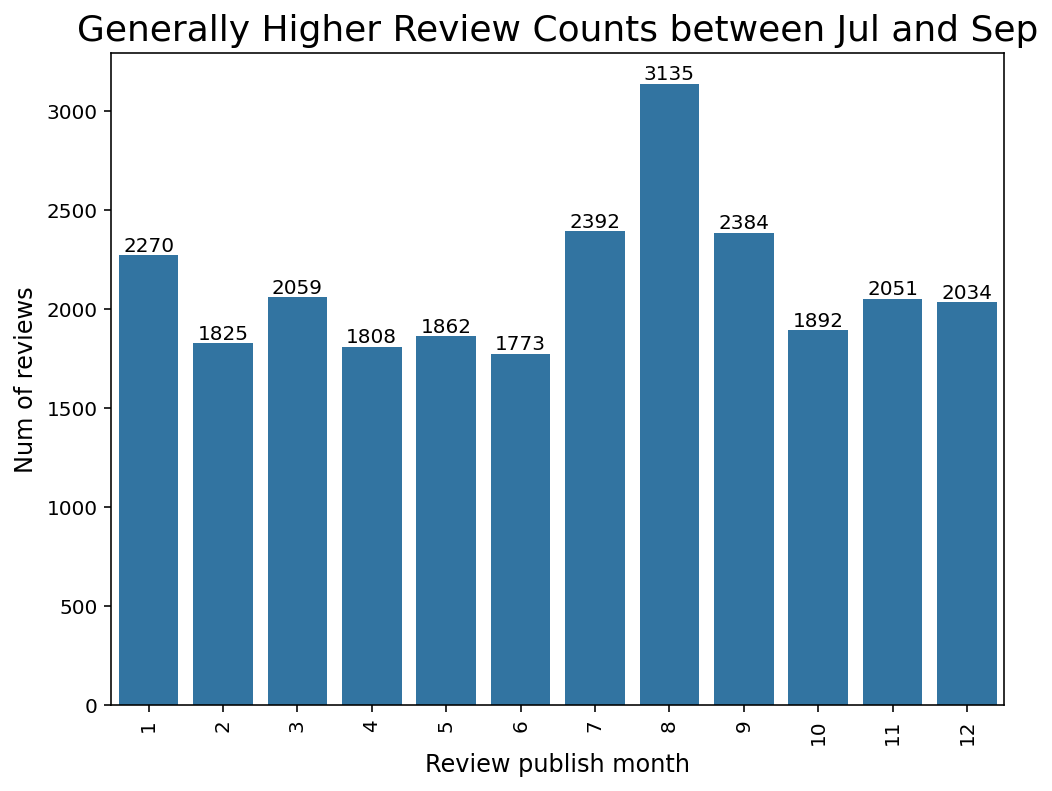

In [24]:
# Plotting in a bar graph of review count by month
plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
plt.title("Generally Higher Review Counts between Jul and Sep", fontsize=18)

ax = sns.barplot(x="review_mth", y="review_count", data=review_mth_df, orient="v", color="tab:blue")
ax.set_xlabel("Review publish month", size=12)
ax.set_ylabel("Num of reviews", size=12)
ax.bar_label(ax.containers[0]);

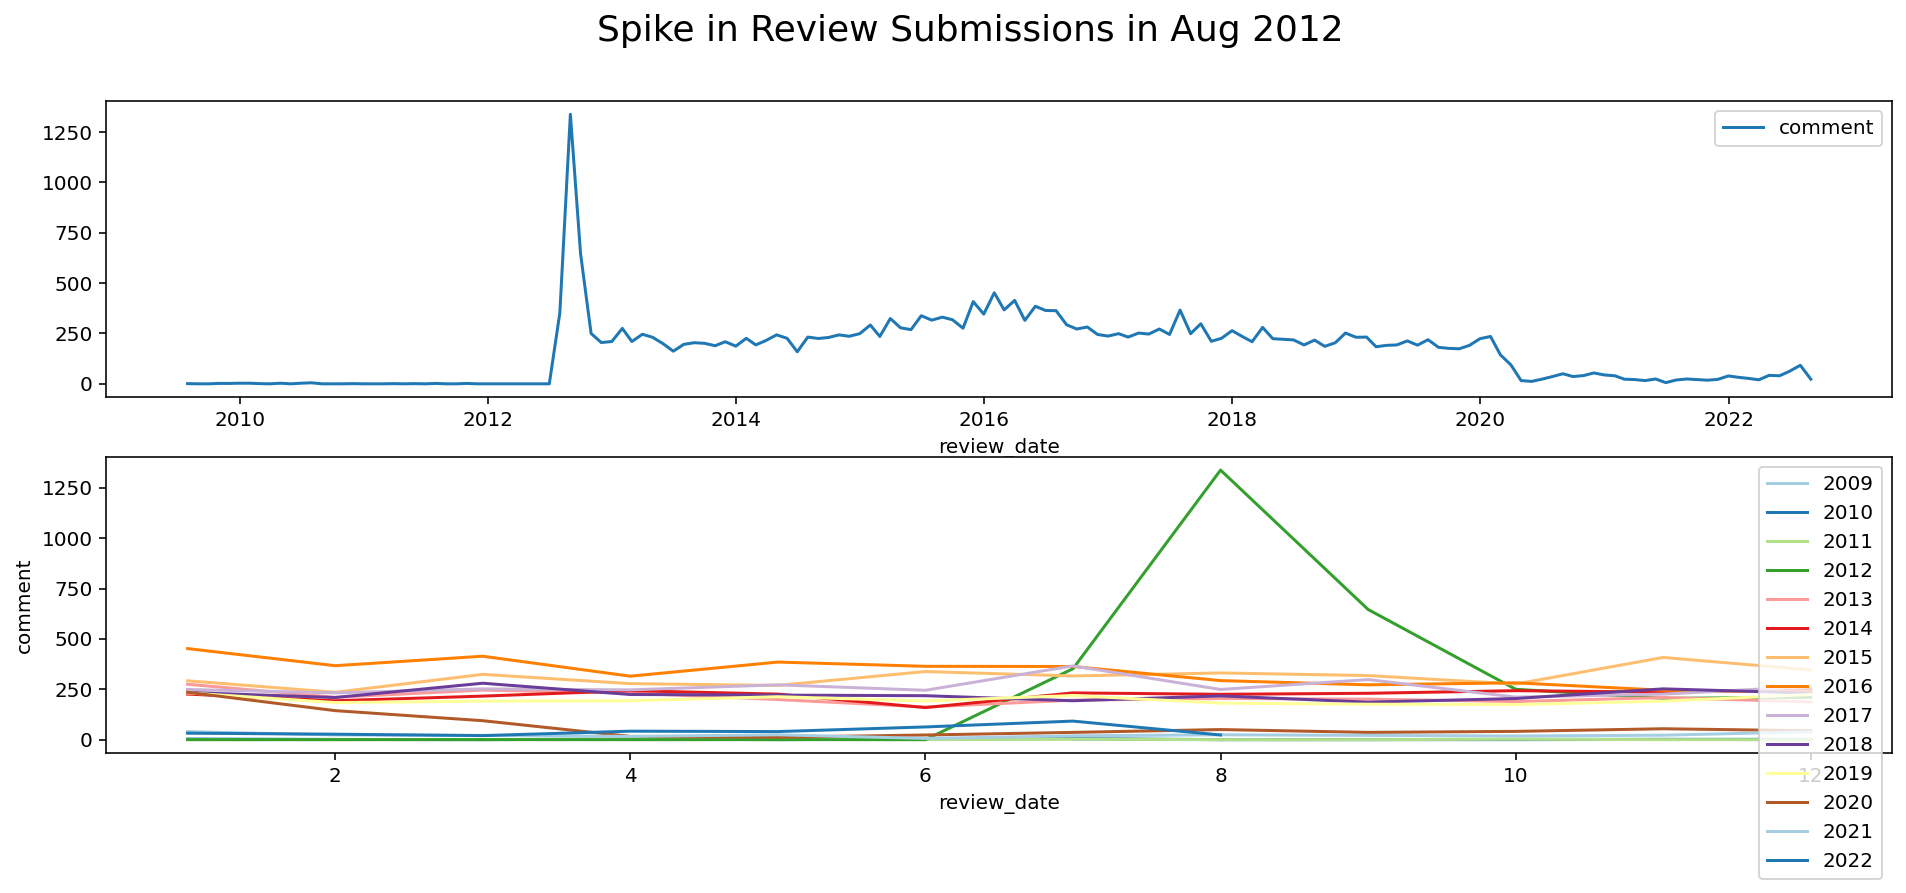

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=(16,6))
plt.suptitle('Spike in Review Submissions in Aug 2012', size=18)

# Plot lineplot of review count by month
sns.lineplot(data=df.groupby(by='review_date').count()[['comment']].resample('M').sum(),
             ax=ax[0]);

# Plot lineplot of review count by month
sns.lineplot(data=df.groupby(by='review_date').count()[['comment']].resample('M').sum(), 
             x=df.groupby(by='review_date').count()[['comment']].resample('M').sum().index.month, 
             y='comment', 
             hue=df.groupby(by='review_date').count()[['comment']].resample('M').sum().index.year,
             palette='Paired',
             ax=ax[1],
             ci=False)
ax[1].legend(loc='upper right');

### Reviews Density Per Category
1. There are a total of 175 categories, with an average of about 248 review submissions per catrgories.
2. However, majority of the categories have between 10 and 288 reviews.
3. The topo three categories with the most number of reviews are Chinese, Cafes and Seafood. 

In [26]:
# Create Dataframe for categories review count. 
cat_sum_df = pd.DataFrame(df[cat_col].sum().sort_values(ascending=False), columns=['sum'])

# Print shape of categories review count dataframe
print(cat_sum_df.shape)

# Display top 20 categories baseed on number of reviews. 
cat_sum_df.head(20)

(175, 1)


,sum
category_chinese,3124
category_cafes,2510
category_seafood,2006
category_bars,1642
category_japanese,1634
category_singaporean,1514
category_asian_fusion,1428
category_indian,1374
category_breakfast_&_brunch,1347
category_italian,1288


In [27]:
# Describe number of reviews per category
cat_sum_df.describe()

,sum
count,175.000000
mean,248.165714
std,463.772191
min,0.000000
25%,10.000000
50%,42.000000
75%,287.500000
max,3124.000000


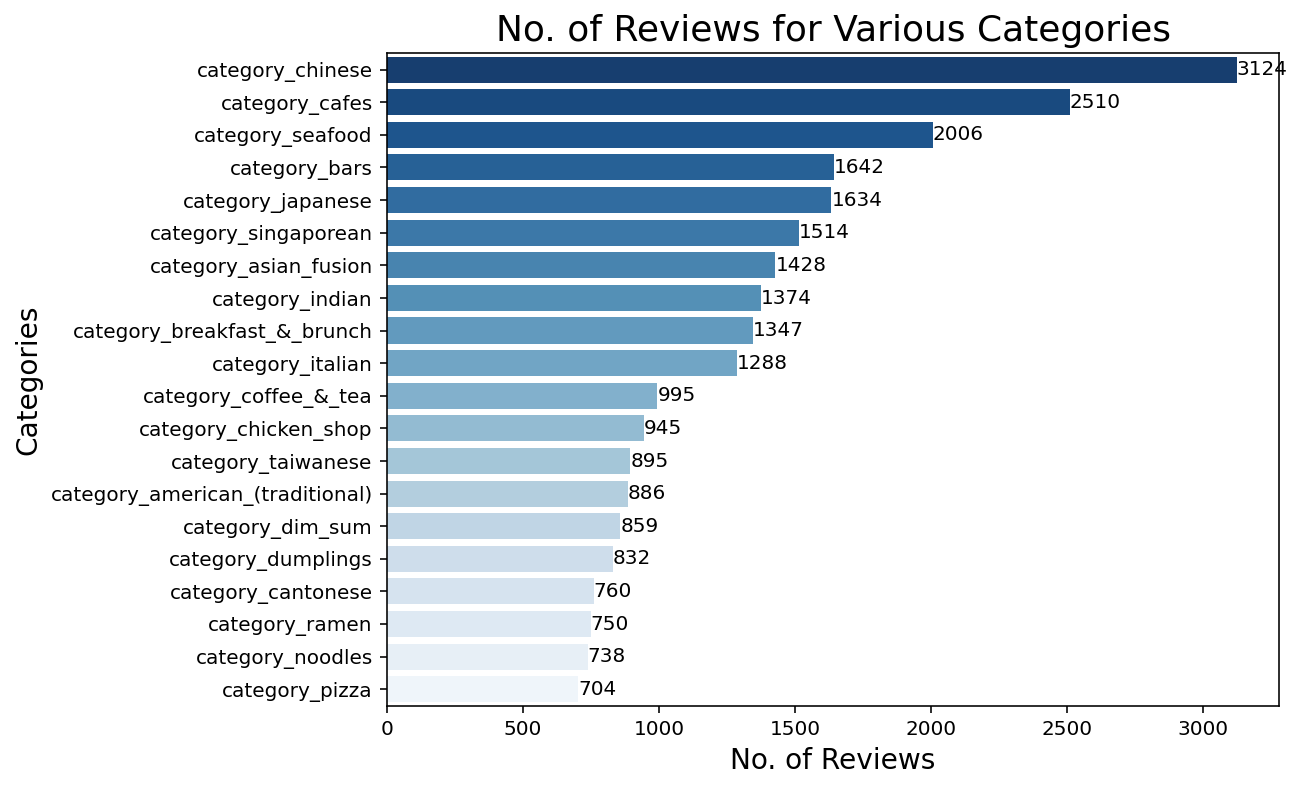

In [28]:
# plot top categories by review count. 
plt.figure(figsize=(8, 6))
plt.title("No. of Reviews for Various Categories", fontsize=18)
ax = sns.barplot(data=cat_sum_df.head(20), 
                 y=cat_sum_df.head(20).index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("No. of Reviews", size=14)
ax.set_ylabel("Categories", size=14)
ax.bar_label(ax.containers[0]);

### Word Count in Reviews
1. Majority of the reviews have between 30 and 100 word count. 

In [29]:
# create a set of stopwords
cust_stopwords = set(stopwords.words('english'))
cust_stopwords |= {'also', 'restaurant', 'would'}

In [30]:
## Creating new feature columns
# Calculate reviews word count

df['word_count'] = df['comment'].apply(lambda body: len([w for w in body.split(" ") if w not in cust_stopwords]))

In [31]:
# Verify column created
df[['word_count']].head()

,word_count
0,34
1,31
2,237
3,42
4,157


In [32]:
# Describe number of words per review.
df['word_count'].describe()

count    25485.000000
mean        78.213302
std         68.167384
min          3.000000
25%         32.000000
50%         58.000000
75%        101.000000
max        576.000000
Name: word_count, dtype: float64

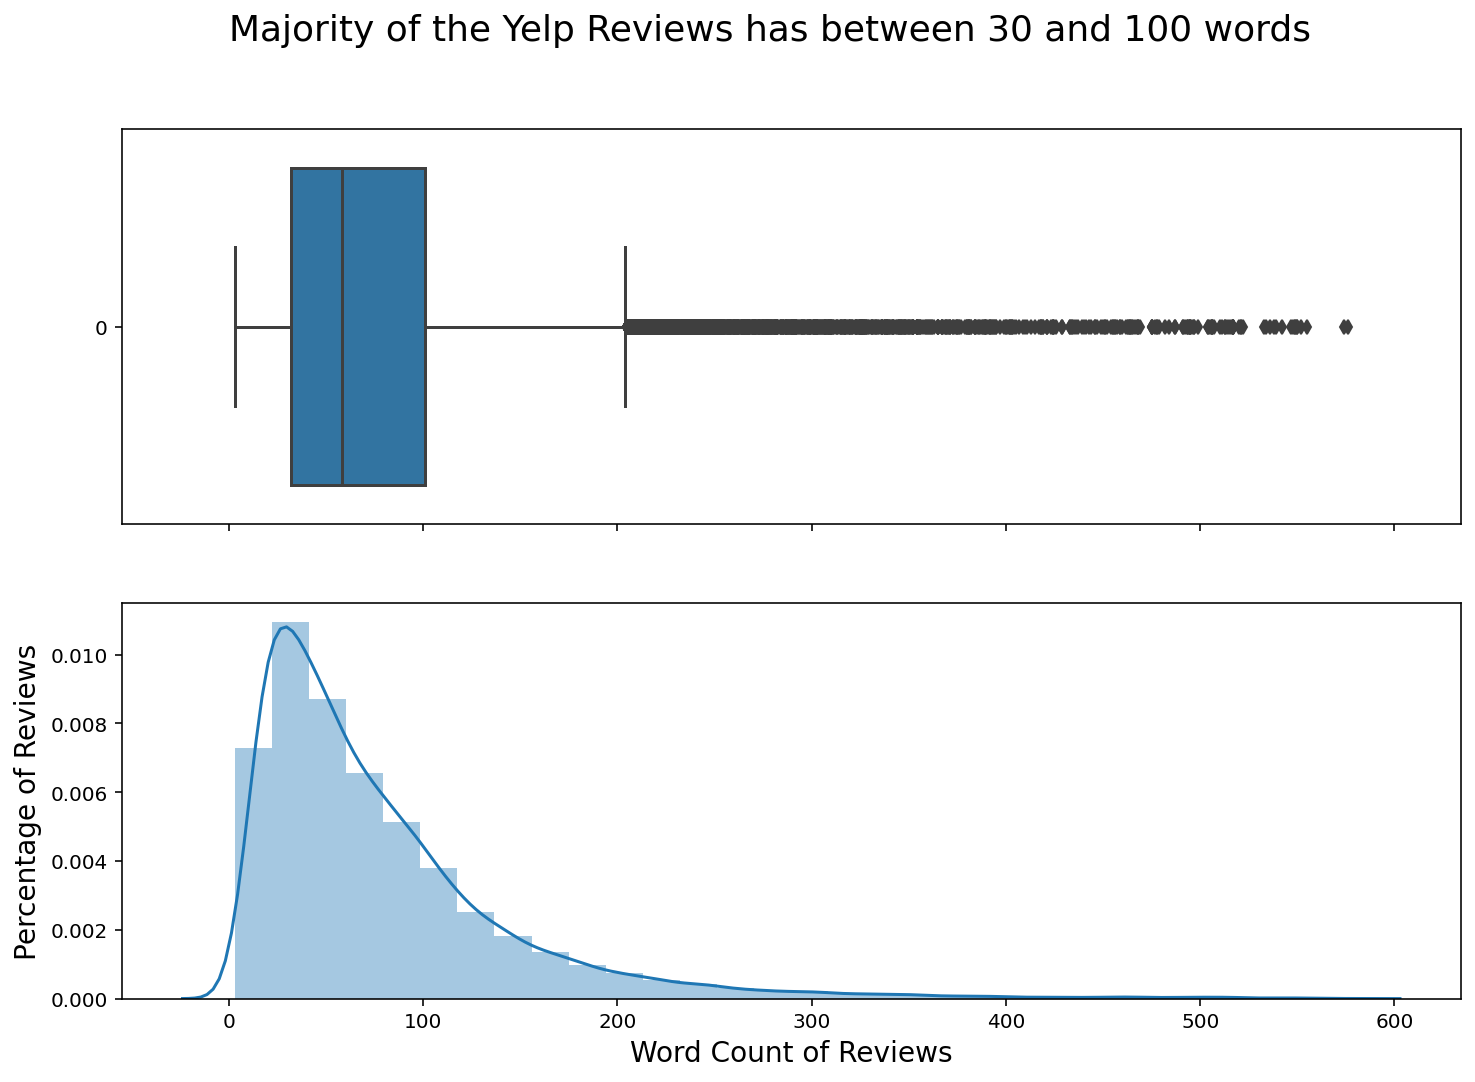

In [33]:
# Boxplot and distribution plot of word count per review with 
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
ax = ax.ravel()

plt.suptitle("Majority of the Yelp Reviews has between 30 and 100 words", size=18)

# Box plot of reviews per user
sns.boxplot(data=df['word_count'], orient='h', ax=ax[0])

# Plotting the distribution
sns.distplot(df['word_count'],
             bins=30, 
             ax=ax[1])
ax[1].set_xlabel("Word Count of Reviews", size=14)
ax[1].set_ylabel("Percentage of Reviews", size=14);

### Top Most Common Words
**Finding Most Common Word**
1. The review-related common words are place, chicken, service, rice and Singapore.
2. Bigrams and Trigrams will be explored to understand more about the comments from users. 

In [34]:
# Instantiate CountVectoriser
cv = CountVectorizer(stop_words=cust_stopwords, min_df=3)

# Fit and transform CountVectoriser
cv.fit(df['comment'])
comment_cv = cv.transform(df['comment'])

# Create Dataframe of words count.
comment_df = pd.DataFrame(comment_cv.todense(), 
                          columns=cv.get_feature_names_out())

In [35]:
# Finding top 15 common words
top_15_words = comment_df.sum().sort_values(ascending=False).head(15).to_frame('sum')
top_15_words.head()

,sum
food,20545
good,19163
place,14237
one,11478
like,11444


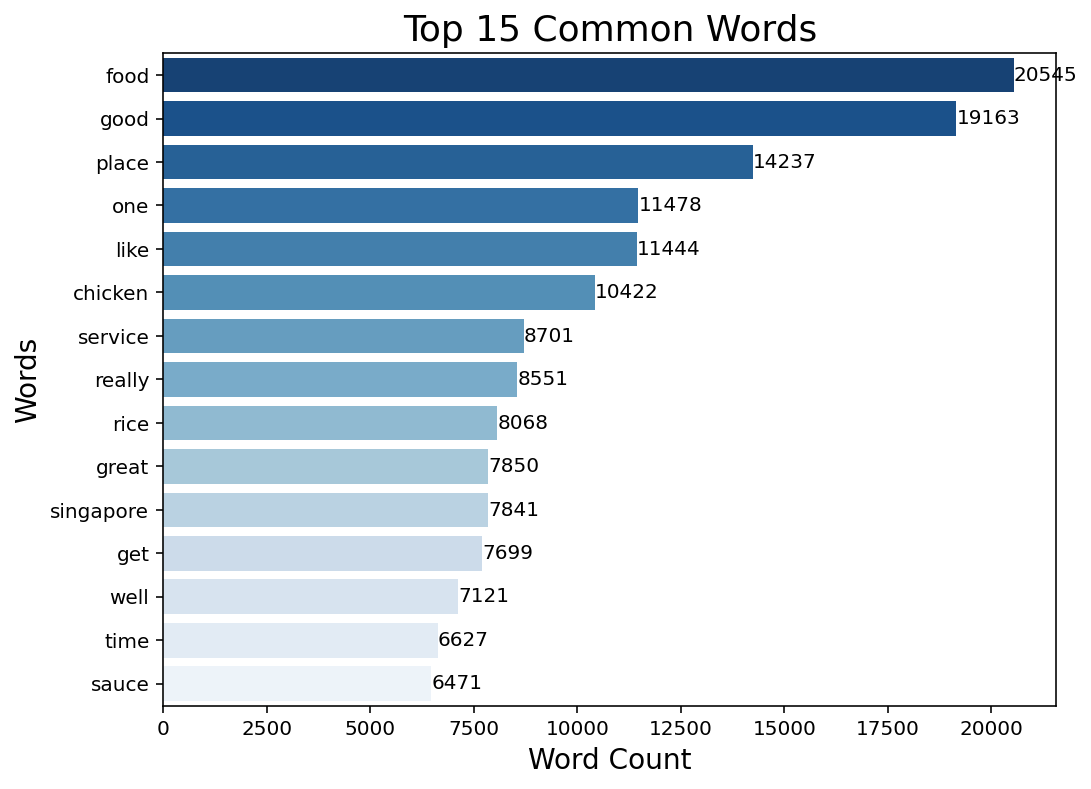

In [36]:
# plot top words. 
plt.figure(figsize=(8, 6))
plt.title("Top 15 Common Words", fontsize=18)
ax = sns.barplot(data=top_15_words, 
                 y=top_15_words.index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("Word Count", size=14)
ax.set_ylabel("Words", size=14)
ax.bar_label(ax.containers[0]);

**Finding Most Common bigrams**
1. The top 5 common meaningful bigrams are chicken rice, dim sum, chilli crab, ice cream and fried rice. 
2. These are food-related bigrams unique to Singapore, except for fried rice. 




In [37]:
# Instantiate CountVectoriser
cv_bigrams = CountVectorizer(ngram_range=(2, 2), 
                              stop_words=cust_stopwords, 
                              min_df=3)

# Fit and transform CountVectoriser
cv_bigrams.fit(df['comment'])
comment_cv_bigrams = cv_bigrams.transform(df['comment'])

# Create Dataframe of words count.
comment_cv_bigrams_df = pd.DataFrame(
    comment_cv_bigrams.todense(), 
    columns=cv_bigrams.get_feature_names_out()
)

In [38]:
# Finding top 15 common words
top_15_bigrams = comment_cv_bigrams_df.sum().sort_values(ascending=False).head(15).to_frame('sum')
top_15_bigrams.head()

,sum
chicken rice,1865
pretty good,1172
dim sum,1162
chili crab,1122
ice cream,1092


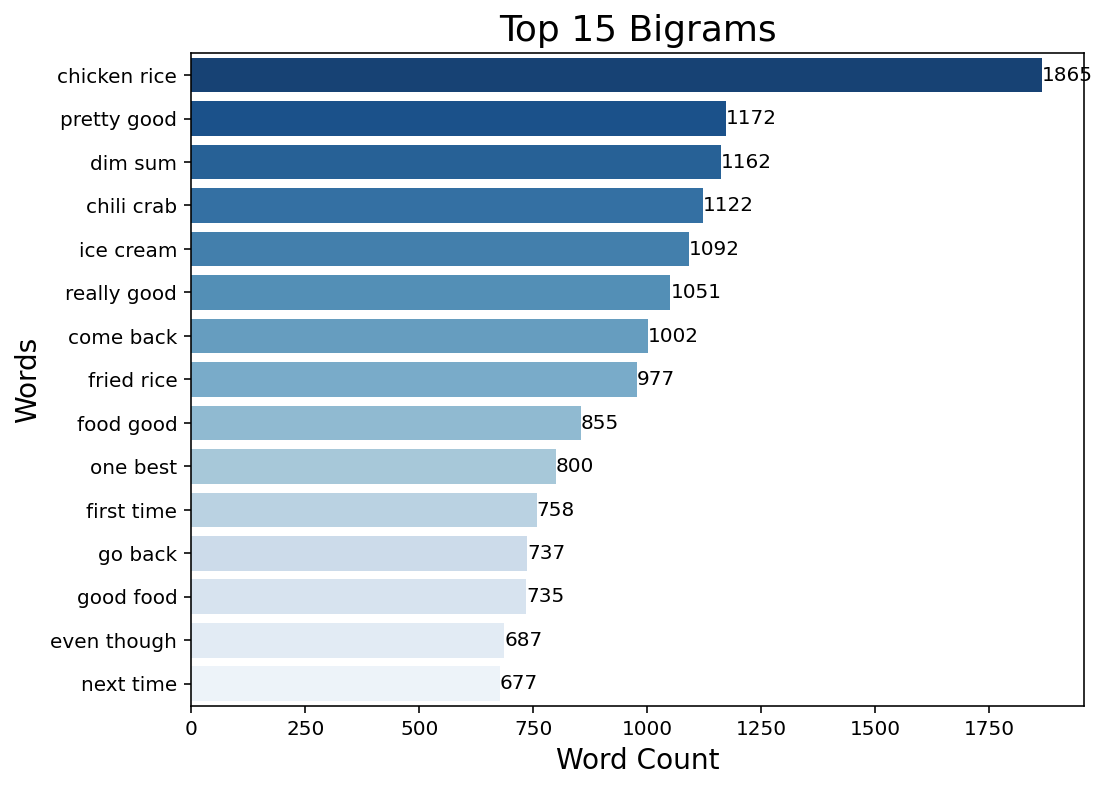

In [39]:
# plot top words. 
plt.figure(figsize=(8, 6))
plt.title("Top 15 Bigrams", fontsize=18)
ax = sns.barplot(data=top_15_bigrams, 
                 y=top_15_bigrams.index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("Word Count", size=14)
ax.set_ylabel("Words", size=14)
ax.bar_label(ax.containers[0]);

**Finding Most Common Trigrams**
1. The top 5 common trigrams are xiao long bao, ding tai fung, bak kut teh, black pepper crab, salted egg yolk. These are food-related trigrams unique to Singapore, except for xiao long bao and ding tai fung. 
2. Other food trigrams unique to Singapore are hainanese chicken rice, char kway teow, fish head curry, vanilla ice cream, bak chor mee, yong tau foo.


In [40]:
# Instantiate CountVectoriser
cv_trigrams = CountVectorizer(ngram_range=(3, 3), 
                              stop_words=cust_stopwords, 
                              min_df=3)

# Fit and transform CountVectoriser
cv_trigrams.fit(df['comment'])
comment_cv_trigrams = cv_trigrams.transform(df['comment'])

# Create Dataframe of words count.
comment_cv_trigrams_df = pd.DataFrame(
    comment_cv_trigrams.todense(), 
    columns=cv_trigrams.get_feature_names_out()
)

In [41]:
# Finding top 15 common words
top_15_trigrams = comment_cv_trigrams_df.sum().sort_values(ascending=False).head(15).to_frame('sum')
top_15_trigrams.head()

,sum
xiao long bao,551
din tai fung,463
bak kut teh,422
black pepper crab,302
salted egg yolk,194


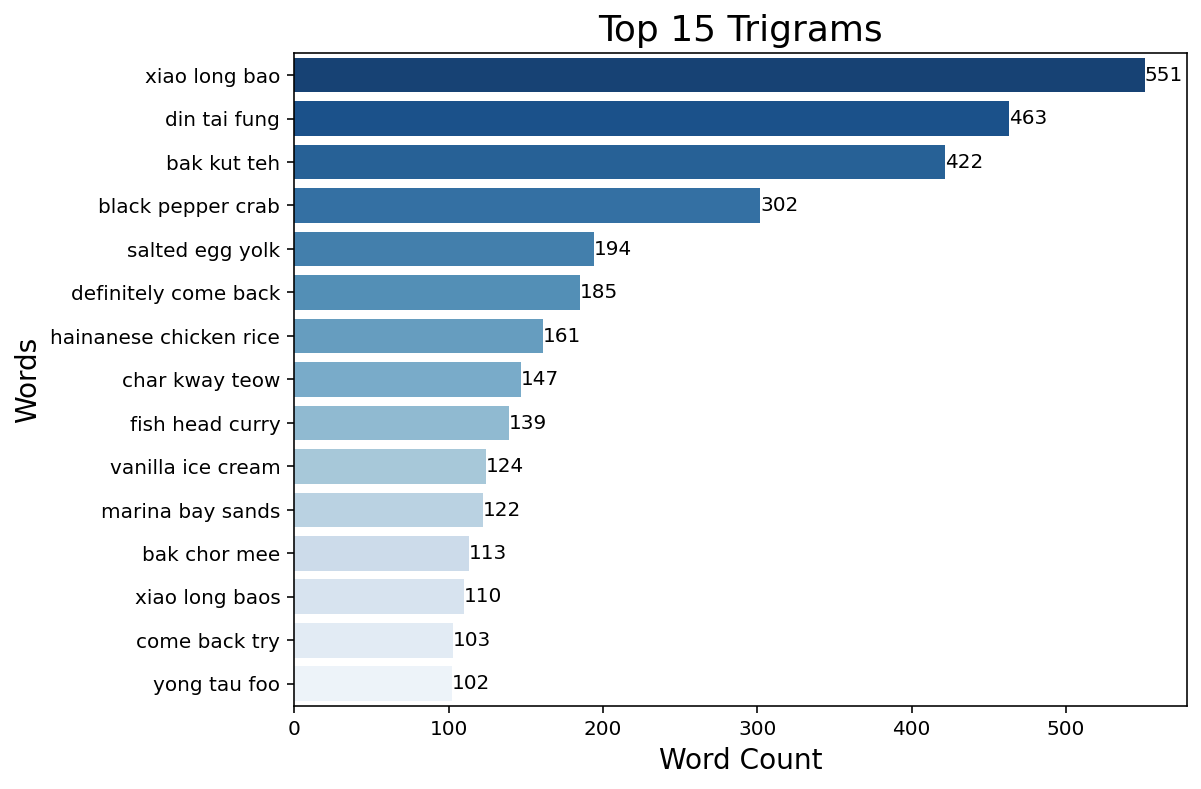

In [42]:
# plot top words. 
plt.figure(figsize=(8, 6))
plt.title("Top 15 Trigrams", fontsize=18)
ax = sns.barplot(data=top_15_trigrams, 
                 y=top_15_trigrams.index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("Word Count", size=14)
ax.set_ylabel("Words", size=14)
ax.bar_label(ax.containers[0]);

### Topic Modelling

1. From the topics modelled, topics 0, 1, 2 are food related. 
2. Topics 0, 1 and 2 seems to suggest more western/japanese, chinese and soup-based food category respectively.
3. topic 3 and 4 are related to service or ambience. 

In [43]:
# Converting words in reviews to a list

def to_words(comments):
    for comment in comments:
        comment = re.sub('\s+', ' ', comment)  # remove newline chars
        comment = re.sub("\'", "", comment)  # remove single quotes
        comment = gensim.utils.simple_preprocess(str(comment), deacc=True) 
        yield(comment)  

In [44]:
# Convert to list

comments = df['comment'].values.tolist()
data_words = list(to_words(comments))
print(data_words[:1])

[['the', 'naked', 'finnwell', 'known', 'for', 'its', 'seafood', 'for', 'dinner', 'which', 'have', 'tried', 'many', 'times', 'before', 'always', 'good', 'especially', 'their', 'cold', 'vermicelli', 'prawns', 'tiny', 'squids', 'had', 'lunch', 'here', 'for', 'the', 'first', 'time', 'limited', 'menu', 'both', 'seafood', 'local', 'food', 'lobster', 'roll', 'was', 'good', 'lobster', 'was', 'not', 'overcooked']]


In [45]:
def process_words(texts, stop_words=cust_stopwords):
    # Remove Stopwords and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    
    lemmatizer = WordNetLemmatizer()
    
    for sent in texts:
        # doc = nlp(" ".join(sent)) 
        texts_out.append([lemmatizer.lemmatize(token) for token in sent])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [91]:
# Process comments
data_processed = process_words(data_words)
data_processed[:1]

[['naked',
  'finnwell',
  'known',
  'seafood',
  'dinner',
  'tried',
  'many',
  'time',
  'always',
  'good',
  'especially',
  'cold',
  'vermicelli',
  'prawn',
  'tiny',
  'squid',
  'lunch',
  'first',
  'time',
  'limited',
  'menu',
  'seafood',
  'local',
  'food',
  'lobster',
  'roll',
  'good',
  'lobster',
  'overcooked']]

In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

In [87]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=42,
                                            chunksize=250,
                                            passes=5,
                                            alpha='auto',
                                            iterations=10,
                                            per_word_topics=False)

In [88]:
# Display topics and content
topics = lda_model.show_topics(formatted=False)
topics

[(0,
  [('pizza', 0.011230892),
   ('salad', 0.00983717),
   ('cake', 0.009064068),
   ('dessert', 0.009019521),
   ('cheese', 0.008309859),
   ('sushi', 0.0082540065),
   ('fry', 0.007843647),
   ('japanese', 0.007637287),
   ('salmon', 0.0067438916),
   ('pasta', 0.0065638125)]),
 (1,
  [('dish', 0.019576034),
   ('fried', 0.018139793),
   ('sauce', 0.016973011),
   ('fish', 0.0128345415),
   ('egg', 0.012250167),
   ('crab', 0.012007328),
   ('rice', 0.011137107),
   ('sweet', 0.010298053),
   ('taste', 0.009865648),
   ('prawn', 0.008388904)]),
 (2,
  [('chicken', 0.049527965),
   ('soup', 0.03945446),
   ('rice', 0.034614634),
   ('noodle', 0.03359573),
   ('pork', 0.023493804),
   ('stall', 0.02027476),
   ('ramen', 0.016560594),
   ('meat', 0.013666515),
   ('bowl', 0.012176017),
   ('broth', 0.009729251)]),
 (3,
  [('food', 0.03473716),
   ('good', 0.030629173),
   ('place', 0.02630024),
   ('great', 0.01194272),
   ('really', 0.011816247),
   ('singapore', 0.010994161),
   ('p

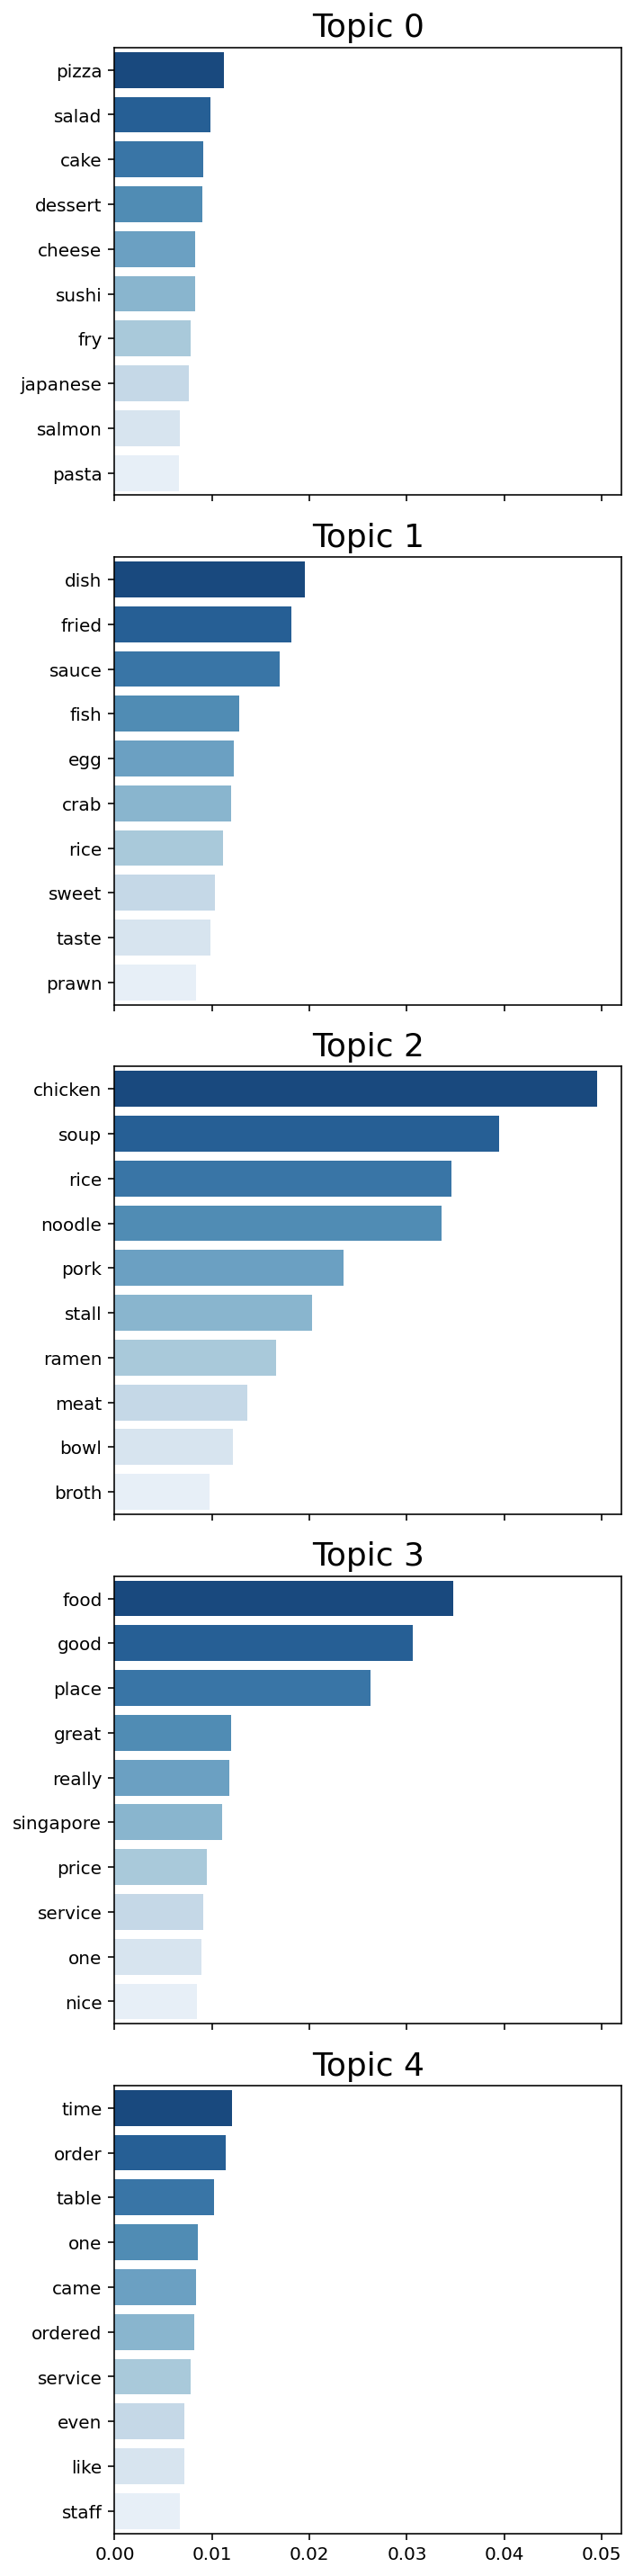

In [89]:
# Plot Top N words in each topic
fig, axes = plt.subplots(5, 1, figsize=(5,20), sharex=True, sharey=False)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    sns.barplot(x=list(list(zip(*topics[i][1]))[1]),
                y=list(list(zip(*topics[i][1]))[0]), 
                palette='Blues_r');
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=18))


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [90]:
# 5 topics

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.197333  0.015512       1        1  31.935492
4      0.245821  0.020497       2        1  28.752428
1     -0.208824 -0.034079       3        1  16.993275
0     -0.084672 -0.238590       4        1  14.496381
2     -0.149658  0.236660       5        1   7.822424, topic_info=         Term          Freq         Total Category  logprob  loglift
1216  chicken  11072.000000  11072.000000  Default  30.0000  30.0000
6        food  22870.000000  22870.000000  Default  29.0000  29.0000
972      rice   8109.000000   8109.000000  Default  28.0000  28.0000
412      soup   6299.000000   6299.000000  Default  27.0000  27.0000
38      place  15839.000000  15839.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
169      side    672.298118   3528.139502   Topic5  -5.3234   0.8904
190     taste    764.517991   6336.276039   Topic5  -5.1949   0.4334
292     sauce    715.210193   6930.992618   Topic5  -5.2616   0.2770
922     spicy    597.568586   2813.268944   Topic5  -5.4413   0.9989
132      like    616.816429  12455.151510   Topic5  -5.4096  -0.4571

[367 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
974       1  0.998835  affordable
974       4  0.001513  affordable
0         1  0.873782      always
0         2  0.032831      always
0         5  0.093372      always
...     ...       ...         ...
428       2  0.997830        yelp
429       1  0.943666       youre
429       2  0.052647       youre
429       4  0.000442       youre
429       5  0.002654       youre

[694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 3])

In [104]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=comments):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        if i%200==0:
            print(f'Completed {i}/{len(ldamodel[corpus])}.')
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['dominant_topic', 'topic_keywords', 'tokens']
    
    print(f'Complete formatting.')
    
    return(sent_topics_df)

In [105]:
# Get columns for topic number and topic_keywords
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_processed)

Completed 0/25485.
Completed 200/25485.
Completed 400/25485.
Completed 600/25485.
Completed 800/25485.
Completed 1000/25485.
Completed 1200/25485.


KeyboardInterrupt: 

In [96]:
# Display first 5 and last 5 rows of dataframe
df_topic_sents_keywords

,dominant_topic,topic_keywords,tokens
0,3,"food, good, place, great, really, singapore, p...","[naked, finnwell, known, seafood, dinner, trie..."
1,4,"time, order, table, one, came, ordered, servic...","[place, quite, difficult, book, even, weekday,..."
2,1,"dish, fried, sauce, fish, egg, crab, rice, swe...","[love, space, anyone, remember, klee, defunct,..."
3,4,"time, order, table, one, came, ordered, servic...","[really, want, like, place, couldnt, yes, appr..."
4,3,"food, good, place, great, really, singapore, p...","[naked, finn, run, ken, loon, met, friend, sin..."
...,...,...,...
25480,4,"time, order, table, one, came, ordered, servic...","[came, lunch, yakitori, stick, nothing, much, ..."
25481,3,"food, good, place, great, really, singapore, p...","[couple, time, love, mookata, comparable, one,..."
25482,1,"dish, fried, sauce, fish, egg, crab, rice, swe...","[taste, jjimdak, seoul, jjimdak, mixture, bone..."
25483,3,"food, good, place, great, really, singapore, p...","[loved, jimdak, portion, tender, succulent, ch..."


In [97]:
# Append new columns onto df
extra_feature_columns = df_topic_sents_keywords[['dominant_topic', 'topic_keywords']]
final_df = pd.concat([df,extra_feature_columns], axis=1)#.reindex(combined_reviews.index)
final_df.head(10)

,rest_name,href,address,postal_code,latitude,longitude,opening,img,star_rating,review_count,...,category_thai,category_dim_sum,category_seafood,category_henghwa,category_kopitiam,category_middle_eastern,local_user,word_count,dominant_topic,topic_keywords
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,1,34,3,"food, good, place, great, really, singapore, p..."
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,1,31,4,"time, order, table, one, came, ordered, servic..."
2,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,1,237,1,"dish, fried, sauce, fish, egg, crab, rice, swe..."
3,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,0,42,4,"time, order, table, one, came, ordered, servic..."
4,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,0,157,3,"food, good, place, great, really, singapore, p..."
5,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,1,103,3,"food, good, place, great, really, singapore, p..."
6,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,0,172,4,"time, order, table, one, came, ordered, servic..."
7,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,0,51,3,"food, good, place, great, really, singapore, p..."
8,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,1,85,3,"food, good, place, great, really, singapore, p..."
9,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,1,0,0,0,1,97,3,"food, good, place, great, really, singapore, p..."


In [98]:
# Save final_reviews into csv file
final_df.to_csv('../data/final_df.csv')

In [56]:
cat_mean_df = pd.DataFrame()

for i, cat in enumerate(cat_col):
    temp_df = df.groupby(by = cat).mean().reset_index(drop=False)
    
    try:
        cat_mean_df.loc[i, 'category'] = cat
        cat_mean_df.loc[i, 'avg_user_rating'] = temp_df.loc[1, 'user_rating']
    except:
        continue
    

In [57]:
cat_mean_df = cat_mean_df.sort_values(by='avg_user_rating', ascending=False)

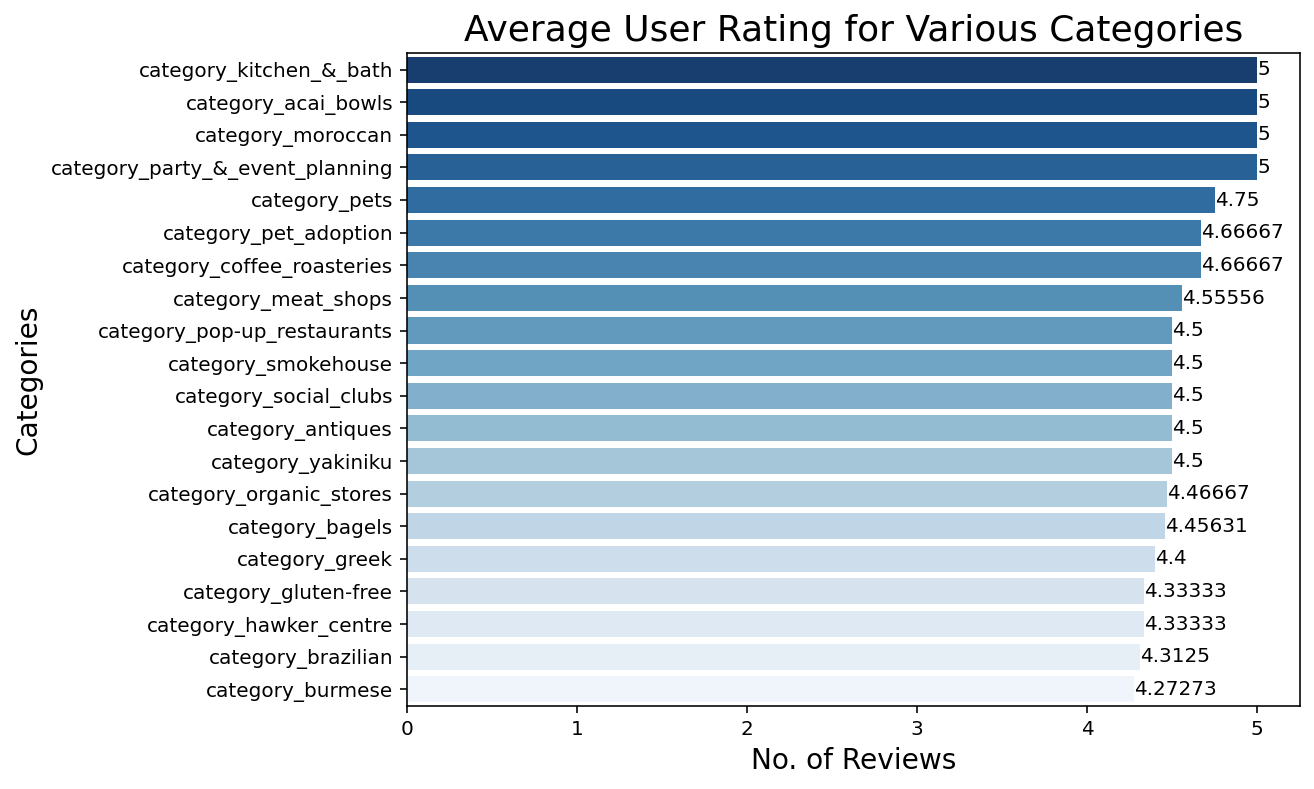

In [58]:
plt.figure(figsize=(8, 6))
plt.title("Average User Rating for Various Categories", fontsize=18)
ax = sns.barplot(data=cat_mean_df.head(20), 
                 y='category', 
                 x='avg_user_rating', 
                 palette='Blues_r');
ax.set_xlabel("No. of Reviews", size=14)
ax.set_ylabel("Categories", size=14)
ax.bar_label(ax.containers[0]);

In [59]:
rating_count_df = df.groupby(['user_rating']).count()[['comment']].sort_values(by='comment', ascending=False)

In [60]:
rating_count_df = rating_count_df.reset_index(drop=False)
rating_count_df

,user_rating,comment
0,4,10382
1,5,7193
2,3,4874
3,2,1672
4,1,1364


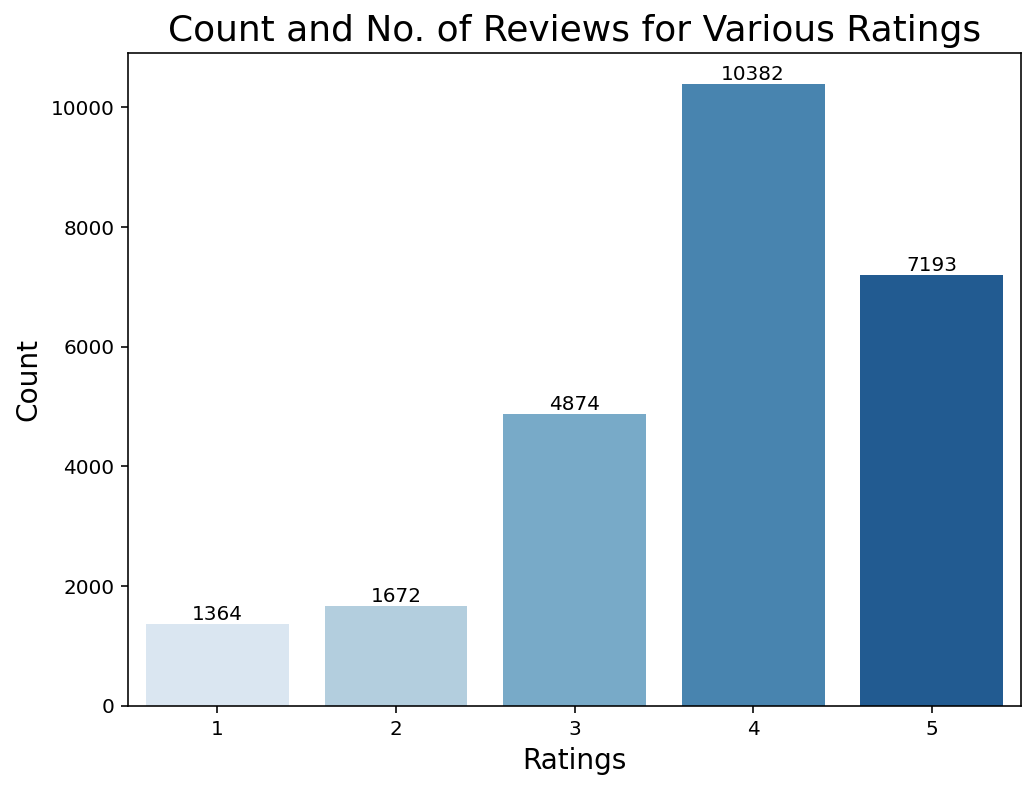

In [61]:
# Plotting the distribution

plt.figure(figsize=(8, 6))
plt.title("Count and No. of Reviews for Various Ratings", fontsize=18)

ax = sns.barplot(data=rating_count_df, x='user_rating', y='comment', palette='Blues')
ax.set_xlabel("Ratings", size=14)
ax.set_ylabel("Count", size=14)
ax.bar_label(ax.containers[0]);

plt.show()

normalise rating before modelling. feature engineering


In [62]:
df[['user_rating']].describe()

,user_rating
count,25485.000000
mean,3.799215
std,1.085058
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


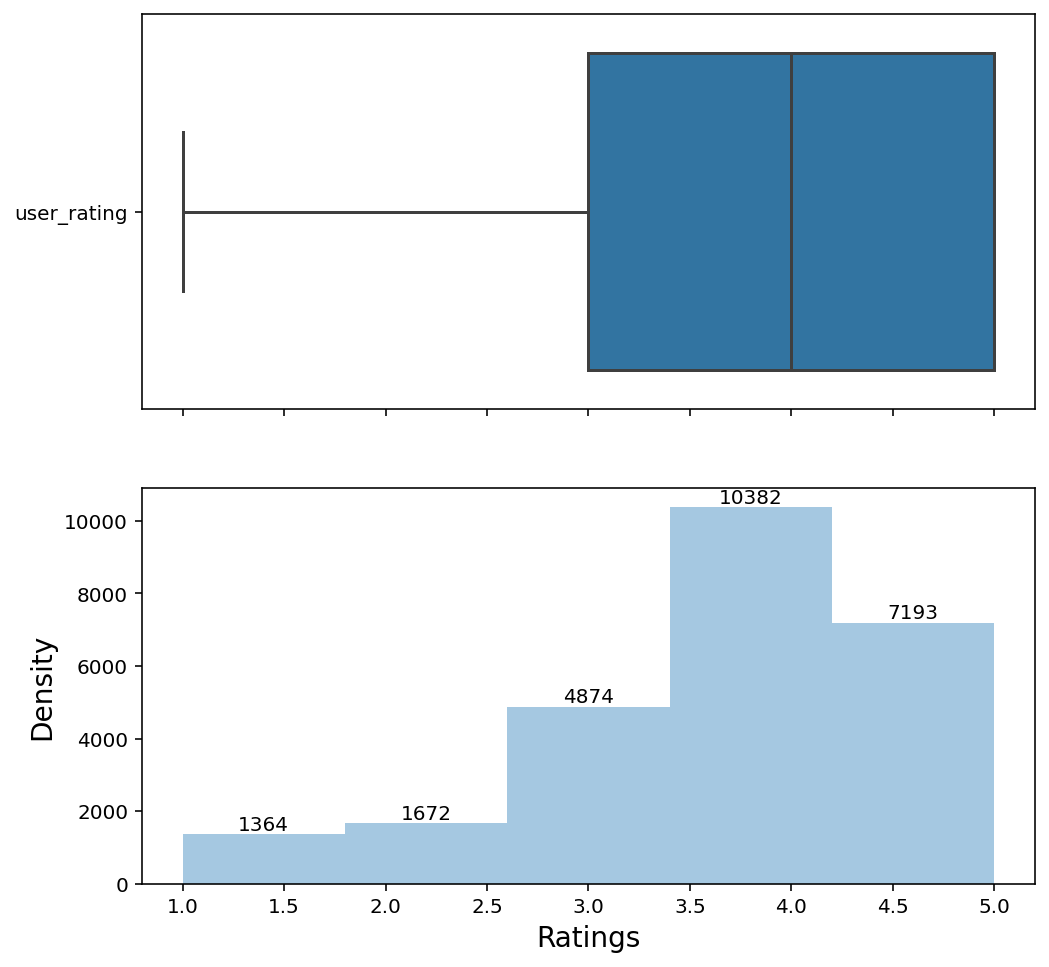

In [63]:
# Boxplot and distribution plot of reviews per user with more than 4 reviews submissions
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 8))
ax = ax.ravel()

plt.suptitle("", size=18)

# Box plot of reviews per user
sns.boxplot(data=df[['user_rating']], orient='h', ax=ax[0])

# Plotting the distribution
sns.distplot(df[['user_rating']], bins=5, ax=ax[1], kde=False)
ax[1].set_xlabel("Ratings", size=14)
ax[1].set_ylabel("Density", size=14)
ax[1].bar_label(ax[1].containers[0]);

plt.show()

In [64]:
location_rating_df = df.groupby(['location']).mean()[['user_rating']].sort_values(by='user_rating', ascending=False)
location_rating_df = location_rating_df.reset_index(drop=False)
location_rating_df

,location,user_rating
0,Tanglin Halt,4.500000
1,Tanjong Pagar,4.111195
2,Mountbatten,4.090909
3,Ubi,4.055556
4,City Hall,4.043883
...,...,...
93,Eunos,3.148936
94,Punggol,3.135135
95,Tuas,2.888889
96,Seletar,2.432432


In [65]:
location_count_df = df.groupby(['location']).count()[['comment']].sort_values(by='comment', ascending=False)
location_count_df = location_count_df.reset_index(drop=False)
location_count_df

,location,comment
0,Clarke Quay,1340
1,Tanjong Pagar,1331
2,Chinatown,1014
3,Orchard,965
4,Arab Street,828
...,...,...
93,Potong Pasir,9
94,Tuas,9
95,Kembangan,9
96,Buangkok,2


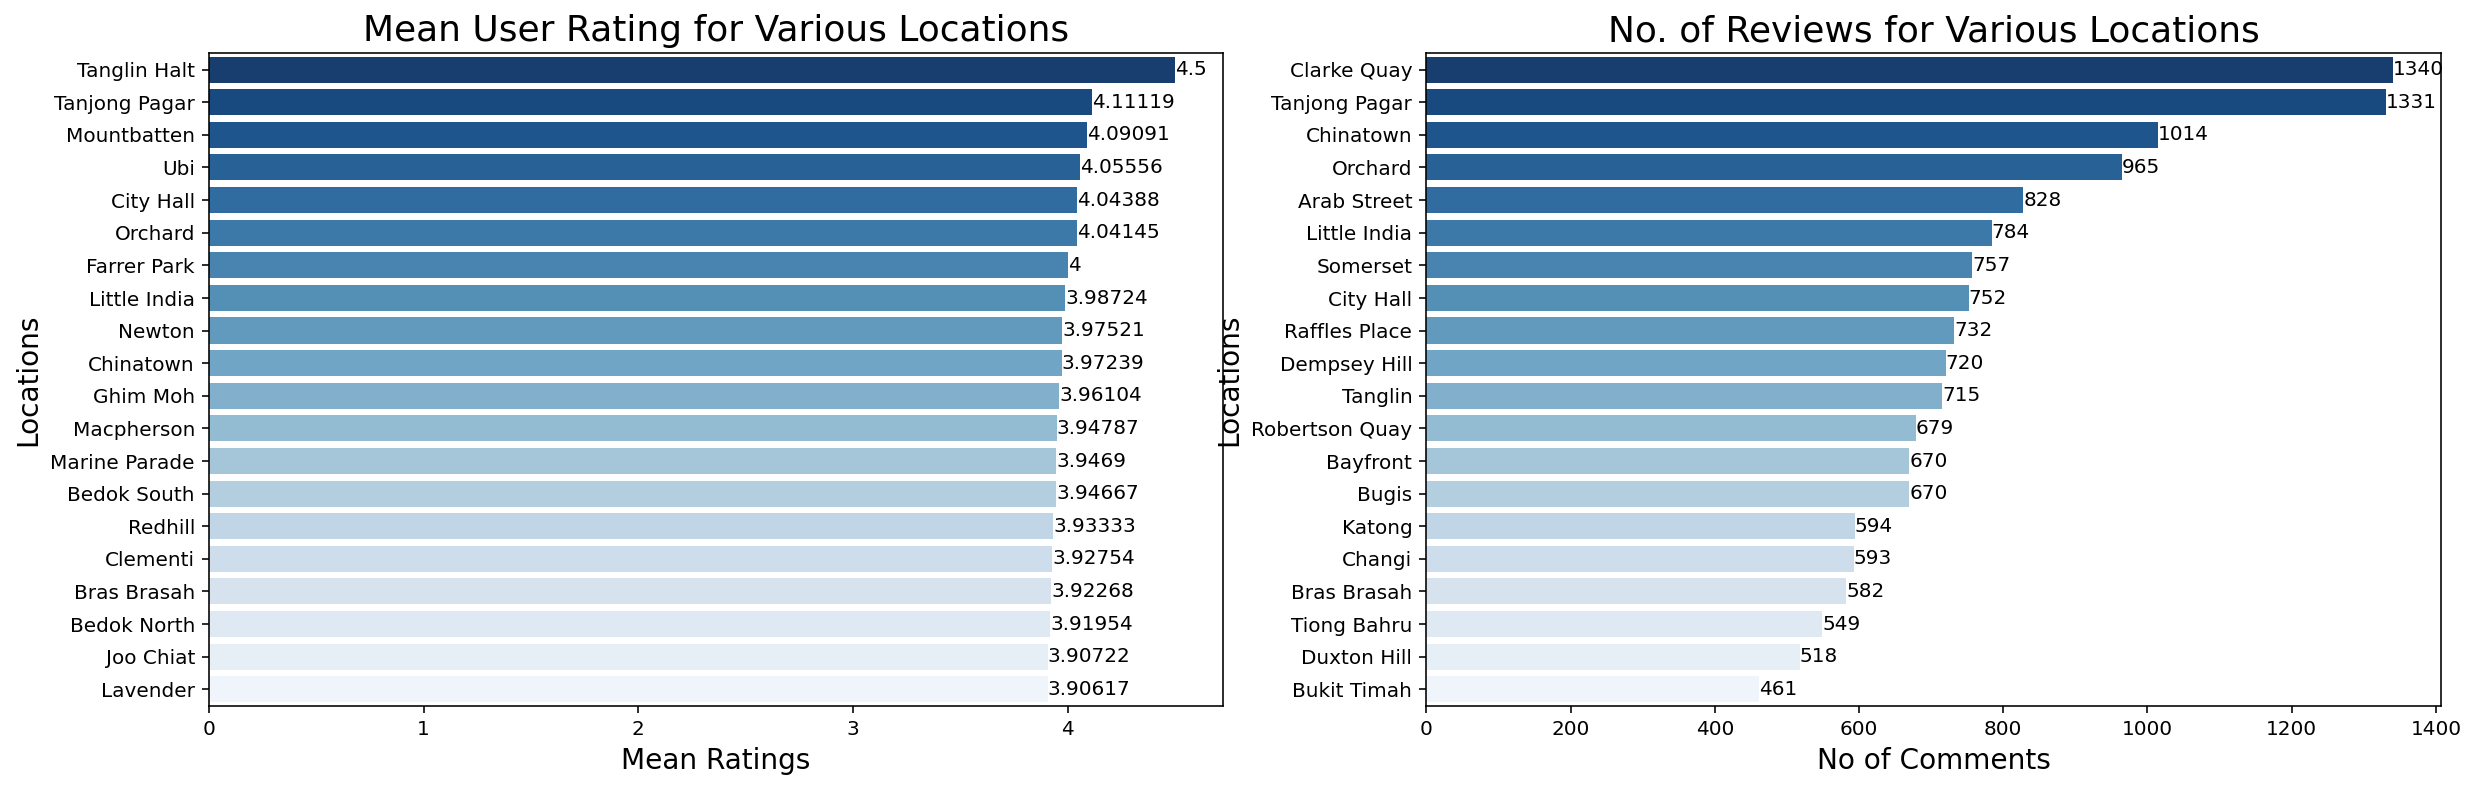

In [66]:
# Plotting the distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.barplot(data=location_rating_df.head(20), y='location', x='user_rating', palette='Blues_r', ax=ax[0])
ax[0].set_title("Mean User Rating for Various Locations", fontsize=18)
ax[0].set_xlabel("Mean Ratings", size=14)
ax[0].set_ylabel("Locations", size=14)
ax[0].bar_label(ax[0].containers[0]);

sns.barplot(data=location_count_df.head(20), y='location', x='comment', palette='Blues_r', ax=ax[1])
ax[1].set_title("No. of Reviews for Various Locations", fontsize=18)
ax[1].set_xlabel("No of Comments", size=14)
ax[1].set_ylabel("Locations", size=14)
ax[1].bar_label(ax[1].containers[0]);

plt.show()

In [67]:
count_rating_df = df.groupby(['rest_name', 'href']).count()[['comment']].sort_values(by='comment', ascending=False)
# count_rating_df = count_rating_df.reset_index(drop=False)
count_rating_df.head()

comment
rest_name                        href                                                       
Tian Tian Hainanese Chicken Rice http://www.yelp.com/biz/tian-tian-hainanese-chi...      345
Jumbo Seafood                    http://www.yelp.com/biz/jumbo-seafood-singapore...      184
                                 http://www.yelp.com/biz/jumbo-seafood-singapore...      176
Din Tai Fung                     http://www.yelp.com/biz/din-tai-fung-singapore-...      175
Jumbo Seafood                    http://www.yelp.com/biz/jumbo-seafood-singapore...      137

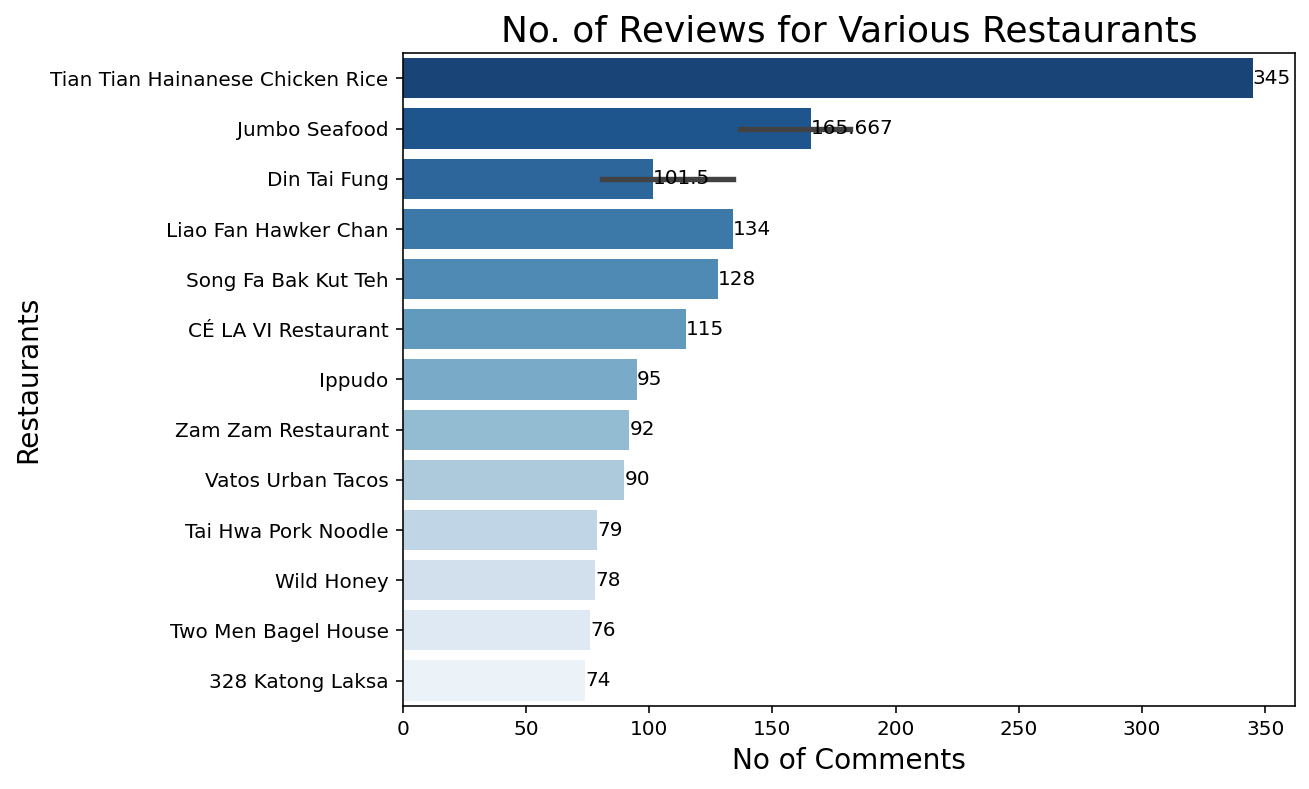

In [68]:
# Plotting the distribution

plt.figure(figsize=(8, 6))
plt.title("No. of Reviews for Various Restaurants", fontsize=18)

ax = sns.barplot(data=count_rating_df.reset_index(drop=False).head(20), y='rest_name', x='comment', palette='Blues_r')
ax.set_xlabel("No of Comments", size=14)
ax.set_ylabel("Restaurants", size=14)
ax.bar_label(ax.containers[0]);

plt.show()

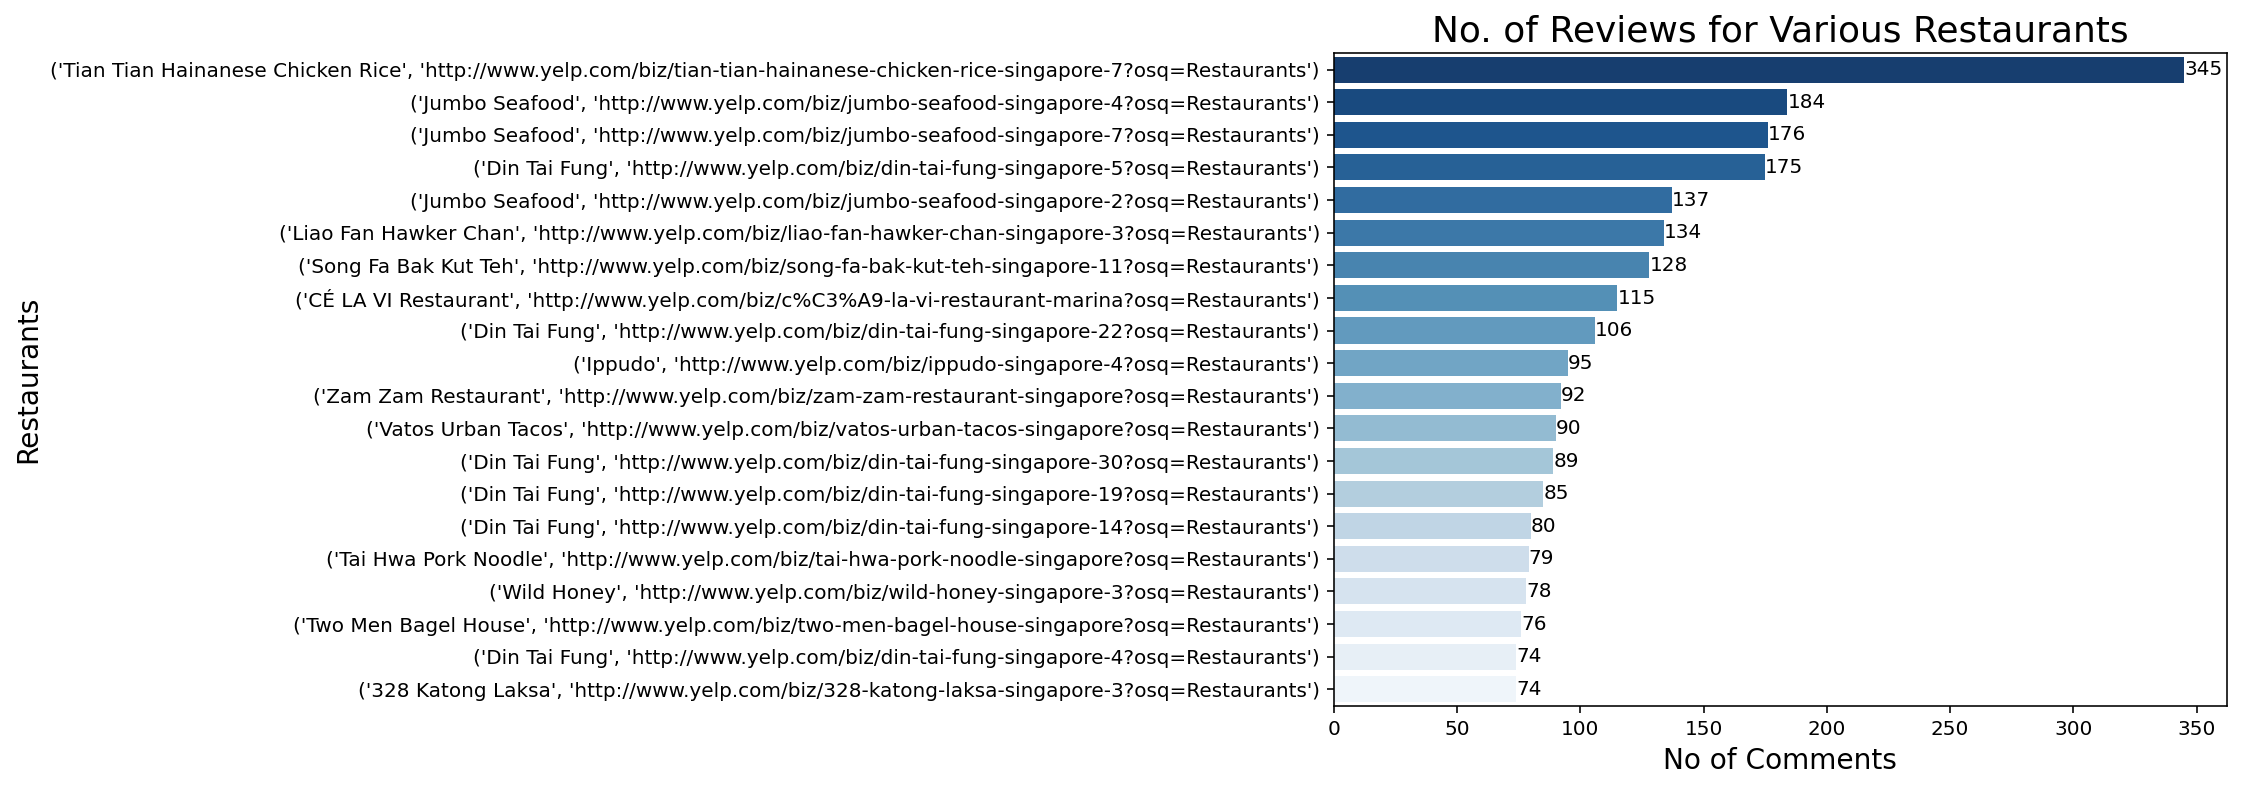

In [69]:
# Plotting the distribution

plt.figure(figsize=(8, 6))
plt.title("No. of Reviews for Various Restaurants", fontsize=18)

ax = sns.barplot(data=count_rating_df.head(20), y=count_rating_df.head(20).index.ravel(), x='comment', palette='Blues_r')
ax.set_xlabel("No of Comments", size=14)
ax.set_ylabel("Restaurants", size=14)
ax.bar_label(ax.containers[0]);

plt.show()

In [70]:
ave_rating_df = df.groupby(['rest_name', 'href']).mean()[['user_rating']].sort_values(by='user_rating', ascending=False)
ave_rating_df[ave_rating_df['user_rating']<5].head(20)

,,user_rating
rest_name,href,
Rhubarb Le Restaurant,http://www.yelp.com/biz/rhubarb-le-restaurant-singapore?osq=Restaurants,4.909091
Sin Heng Kee Porridge,http://www.yelp.com/biz/sin-heng-kee-porridge-singapore?osq=Restaurants,4.900000
Man Man Japanese Unagi,http://www.yelp.com/biz/man-man-japanese-unagi-singapore?osq=Restaurants,4.888889
Tandoori Culture,http://www.yelp.com/biz/tandoori-culture-singapore?osq=Restaurants,4.888889
Nangfa Thai Kitchen,http://www.yelp.com/biz/nangfa-thai-kitchen-singapore?osq=Restaurants,4.857143
Sanji Kagoshima Ramen,http://www.yelp.com/biz/sanji-kagoshima-ramen-singapore?osq=Restaurants,4.857143
The Malayan Council,http://www.yelp.com/biz/the-malayan-council-singapore-2?osq=Restaurants,4.857143
Sushi Kimura Singapore,http://www.yelp.com/biz/sushi-kimura-singapore-singapore?osq=Restaurants,4.833333
Zazz Pizza,http://www.yelp.com/biz/zazz-pizza-singapore?osq=Restaurants,4.833333


read up
1. matrix factorisation 
2. 

# <center> END OF NOTEBOOK </center>